In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

experiment_names = ['owl_exp_pure',
                    'owl_exp_mixed',
                    'strike_exp_pure',
                    'strike_exp_mixed',
                    'energy_gain_pure',
                    'energy_gain_mixed',
                    ]
totals = []
point_class_dfs = []
parameters = []
for label in experiment_names:
    file_path_pcs = '/home/mremington/Documents/krattle_analysis/krattle_analysis/per_cycle_analysis/data/{}_point_classifacation.csv'.format(label)
    temp_exp_pc = pd.read_csv(file_path_pcs,header = 0, index_col=None)
    point_class_dfs.append(temp_exp_pc)
    for i in range(1,7):
        file_path_totals = '/home/mremington/Documents/uumarrty_exps/{}/exp{}/Data/totals.csv'.format(label,i)
        temp_exp_total = pd.read_csv(file_path_totals,header = 0, index_col=None)
        temp_exp_total['experiment_name'] = [label for i in range(len(temp_exp_total))]
        totals.append(temp_exp_total)
        file_path_parameters = '/home/mremington/Documents/uumarrty_exps/{}/exp{}/Data/parameters.csv'.format(label,i)
        temp_exp_par = pd.read_csv(file_path_parameters,header = 0, index_col=None)
        temp_exp_par['experiment_name'] = [label for i in range(len(temp_exp_par))]
        parameters.append(temp_exp_par)

        
totals = pd.concat(totals, ignore_index=False)
pc_dfs = pd.concat(point_class_dfs, ignore_index=False)
par= pd.concat(parameters, ignore_index=False)

result = pd.merge(pc_dfs,
                  totals[['sim_id','data_type','mean_bush_pref']],
                  how="left",
                  left_on=['sim_id','org'],
                  right_on=["sim_id", "data_type"])

result['figure_label'] = [x[-1] for x in list(result['exp'])]

def format_title(exp_title,remove_exp_type=False):
    if remove_exp_type:
        title = exp_title.replace("_", " ").replace('pure','').replace('mixed','').title()
    else:
        title=exp_title.replace("_", " ").title()
    return title

def temp_data(df,filter_val):
    return df[df['exp_name']==filter_val]

def format_bar_chart_data(temp):
    bp_df = temp.groupby(['figure_label','org']).agg(
    # Get max of the duration column for each group
    Bush=pd.NamedAgg(column='mean_bush_pref', aggfunc='mean'),
    #     exp_std_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='std'),
    #     exp_se_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='sem')
        )
    #bp_df = bp_df.reset_index()
    open_preference = [1-x for x in list(bp_df['Bush'])]
    bp_df['Open']= open_preference
    bp_df = bp_df.unstack(level=-1)
    #bp_df=bp_df.iloc[::-1]
    #bp_df = bp_df[bp_df.columns[::-1]]
    return bp_df

def get_data(exp_label):
    data = result[result['exp_name']==exp_label].groupby(['figure_label','org']).agg(
        Bush=pd.NamedAgg(column='mean_bush_pref', aggfunc='mean'),
        )
    open_preference = [1-x for x in list(data['Bush'])]
    data['Open']= open_preference
    data = data.unstack(level=-1)
    data=data.reset_index()
    data.columns=['Experimental_Group','krat_bush','snake_bush','krat_open','snake_open']
    data.set_index('Experimental_Group', inplace=True)
    return data

def get_chart(name):
    path = "/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/yaxis_labels/{}.png".format(name)
    im = plt.imread(path)
    return im


def offset_image(coord, name, ax, zoom=0.15,xval=-30):
    img = get_chart(name)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(im, (0, coord-1),  xybox=(xval, 0), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)
    
def get_legend(abrev_name,coord,ax,zoom=1,x=0,y=0):
    path = "/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/Legends/{}_legend.png".format(abrev_name)
    im = plt.imread(path)
    im = OffsetImage(im, zoom=zoom)
    ab = AnnotationBbox(im, (0, 0),  xybox=(x, y), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)
    

In [3]:
initial_parm = par[['experiment_name','sim_id','initial_owl_pop','initial_snake_pop','krat_energy_gain_bush','krat_energy_gain_open','snake_strike_success_probability_bush','snake_strike_success_probability_open']]

initial_parm = pd.merge(initial_parm,
                  result[['sim_id','figure_label']],
                  how="left",
                  left_on=['sim_id'],
                  right_on=["sim_id"])
initial_exp_groups=[]
for i in experiment_names:
    if i in ['owl_exp_pure','owl_exp_mixed']:
        df_owl=initial_parm[initial_parm['experiment_name'].isin(['owl_exp_pure','owl_exp_mixed'])].groupby(by=['figure_label'])['initial_owl_pop','initial_snake_pop'].max()
        df_owl=df_owl.reset_index()
    elif i in ['strike_exp_pure','strike_exp_mixed']:
        df_ss=initial_parm[initial_parm['experiment_name'].isin(['strike_exp_pure','strike_exp_mixed'])].groupby(by=['figure_label'])['snake_strike_success_probability_bush','snake_strike_success_probability_open'].max()
        df_ss=df_ss.reset_index()
    elif i in ['energy_gain_pure','energy_gain_mixed']:
        df_eg=initial_parm[initial_parm['experiment_name'].isin(['energy_gain_pure','energy_gain_mixed'])].groupby(by=['figure_label'])['krat_energy_gain_bush','krat_energy_gain_open',].max()
        df_eg = df_eg.reset_index()

<ipython-input-3-11ad31e927ce>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_owl=initial_parm[initial_parm['experiment_name'].isin(['owl_exp_pure','owl_exp_mixed'])].groupby(by=['figure_label'])['initial_owl_pop','initial_snake_pop'].max()
<ipython-input-3-11ad31e927ce>:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ss=initial_parm[initial_parm['experiment_name'].isin(['strike_exp_pure','strike_exp_mixed'])].groupby(by=['figure_label'])['snake_strike_success_probability_bush','snake_strike_success_probability_open'].max()
<ipython-input-3-11ad31e927ce>:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_eg=initial_parm[initial_parm['experiment_name'].isin(['energy_gain_pure','energy_gain_mixed'])].groupby(by=['figure_label'])['krat_e

In [4]:
result['log_mgsf'] = np.log(result['mean_strategy_flip_time'])

In [5]:
result.head()

,exp_name,sim_id,exp,org,count_str_flip,mean_strategy_flip_time,std_strategy_flip_time,var_strategy_flip_time,mean_magnitude_of_strategy_flip,std_magnitude_of_strategy_flip,var_magnitude_of_strategy_flip,data_type,mean_bush_pref,figure_label,log_mgsf
0,owl_exp_pure,06028c5bc0bb4674a7d322d9ac32ed5e,experiment1,krat,356,16.833803,12.288573,151.009024,0.843390,0.360106,0.129677,krat,0.514374,1,2.823389
1,owl_exp_pure,06028c5bc0bb4674a7d322d9ac32ed5e,experiment1,snake,373,2.663978,1.234060,1.522904,0.887674,0.263518,0.069442,snake,0.494487,1,0.979821
2,owl_exp_pure,078a550708c94ad589f54acb02b8b55a,experiment1,krat,385,15.484375,10.767651,115.942314,0.805410,0.393076,0.154509,krat,0.547678,1,2.739831
3,owl_exp_pure,078a550708c94ad589f54acb02b8b55a,experiment1,snake,383,2.591623,1.096754,1.202869,0.909786,0.211419,0.044698,snake,0.463121,1,0.952284
4,owl_exp_pure,0ebf538877ac46fda69541db6a494fa0,experiment1,krat,372,16.123989,10.884938,118.481882,0.852848,0.351398,0.123480,krat,0.504739,1,2.780308


In [3]:
bp_df = result.groupby(['exp_name','figure_label','org']).agg(
    # Get max of the duration column for each group
    exp_mean_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='mean'),
#     exp_std_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='std'),
#     exp_se_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='sem')
    )
#bp_df = bp_df.reset_index()
bp_df = bp_df.unstack(level=-1) 
# bp_df.head()   

In [7]:
#make owl fig

In [10]:
#https://stackoverflow.com/questions/44246650/add-image-annotations-to-bar-plots/44264051#44264051

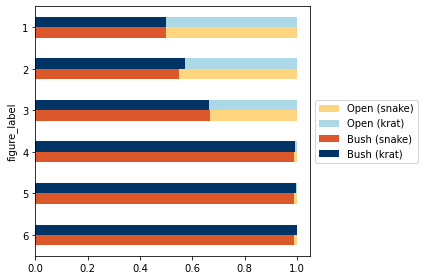

In [4]:
bp_df = result[result['exp_name']=='owl_exp_pure'].groupby(['figure_label','org']).agg(
    # Get max of the duration column for each group
    Bush=pd.NamedAgg(column='mean_bush_pref', aggfunc='mean'),
#     exp_std_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='std'),
#     exp_se_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='sem')
    )
#bp_df = bp_df.reset_index()
open_preference = [1-x for x in list(bp_df['Bush'])]
bp_df['Open']= open_preference
bp_df = bp_df.unstack(level=-1)
bp_df=bp_df.iloc[::-1]
bp_df = bp_df[bp_df.columns[::-1]]
#bp_df_owl = bp_df[bp_df['exp_name']=='owl_exp_pure']
#bp_df.head()
# bp_df.head()
colors = [
         '#ADD8E6', #light blue
         '#FFD580', #light Orange
         '#003366', #Dark Blue
         '#DC582A', # Dark Orange
         
         ] 
fig, ax = plt.subplots()

(bp_df['Bush']+bp_df['Open']).plot(kind='barh', color=[colors[1], colors[0]], rot=0, ax=ax)
(bp_df['Bush']).plot(kind='barh', color=[colors[3], colors[2]], rot=0, ax=ax)
#df0['Val3'].plot(kind='bar', color=[colors[5], colors[4]], rot=0, ax=ax)

#legend_labels = ['Open (Krat)','Open (Snake)','Bush (Krat)','Bush (Snake)']
legend_labels = [f'{val} ({context})' for val, context in bp_df.columns]
ax.legend(legend_labels,loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


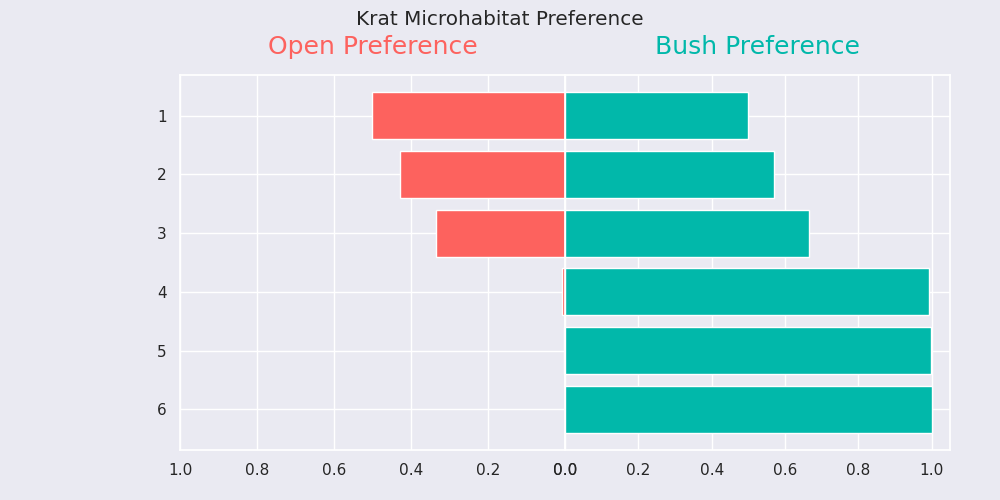

Text(0.5, 0.98, 'Krat Microhabitat Preference')

In [4]:
%matplotlib notebook
sns.set()
bp_df = result[result['exp_name']=='owl_exp_pure'].groupby(['figure_label','org']).agg(
    Bush=pd.NamedAgg(column='mean_bush_pref', aggfunc='mean'),
    )
#bp_df = bp_df.reset_index()
open_preference = [1-x for x in list(bp_df['Bush'])]
bp_df['Open']= open_preference
bp_df = bp_df.unstack(level=-1)
bp_df=bp_df.reset_index()
bp_df.columns=['Experimental_Group','krat_bush','snake_bush','krat_open','snake_open']
bp_df.set_index('Experimental_Group', inplace=True)


font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = bp_df.index
column0 = bp_df['krat_open']
column1 = bp_df['krat_bush']
title0 = 'Open Preference'
title1 = 'Bush Preference'
fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)
axes[0].set(xlim=(0,1))
axes[0].invert_xaxis()
plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
fig.suptitle("Krat Microhabitat Preference")

# plt.tight_layout()
# plt.show()

In [27]:
help(add_gridspec)

NameError: name 'add_gridspec' is not defined

In [6]:
%matplotlib notebook
from matplotlib import gridspec




# font_color = '#525252'
# hfont = {'fontname':'Calibri'}
# facecolor = '#eaeaf2'
# color_red = '#fd625e'
# color_blue = '#01b8aa'
# index = bp_df.index
# column0 = bp_df['krat_open']
# column1 = bp_df['krat_bush']
# title0 = 'Open Preference'
# title1 = 'Bush Preference'

#fig = plt.figure(figsize=(18, 9))




# left = fig.add_gridspec(3, 2, wspace=0.1, hspace=0.5, left=0.03, right=0.98, bottom=0.03, top=0.9)
# grid = plt.GridSpec(3, 1)

# for i in range(3):
#     for j in range(2):
#         right = left[i, j].subgridspec(1, 2, wspace=0, hspace=0.25,width_ratios=[0.5, 0.5]) #height_ratios=[0.15, 0.85]
#         axes = right.subplots(sharey=True)
#         axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
#         axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
#         axes[0].invert_yaxis()
#         axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
#         axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)
#         axes[0].set(xlim=(0,1))
#         axes[0].invert_xaxis()
#         axes[1].invert_yaxis() # if you want the histogram upside down
# fig.suptitle("Krat Microhabitat Preference")
# plt.show()
    

In [12]:
help(plt.barh)

Help on function barh in module matplotlib.pyplot:

barh(y, width, height=0.8, left=None, *, align='center', **kwargs)
    Make a horizontal bar plot.
    
    The bars are positioned at *y* with the given *align*\ment. Their
    dimensions are given by *width* and *height*. The horizontal baseline
    is *left* (default 0).
    
    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.
    
    Parameters
    ----------
    y : float or array-like
        The y coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    width : float or array-like
        The width(s) of the bars.
    
    height : float or array-like, default: 0.8
        The heights of the bars.
    
    left : float or array-like, default: 0
        The x coordinates of the left sides of the bars.
    
    align : {'center', 'edge'}, default: 'center'
        Alignment of the base to the *y* coordinates*:
 

<IPython.core.display.Javascript object>


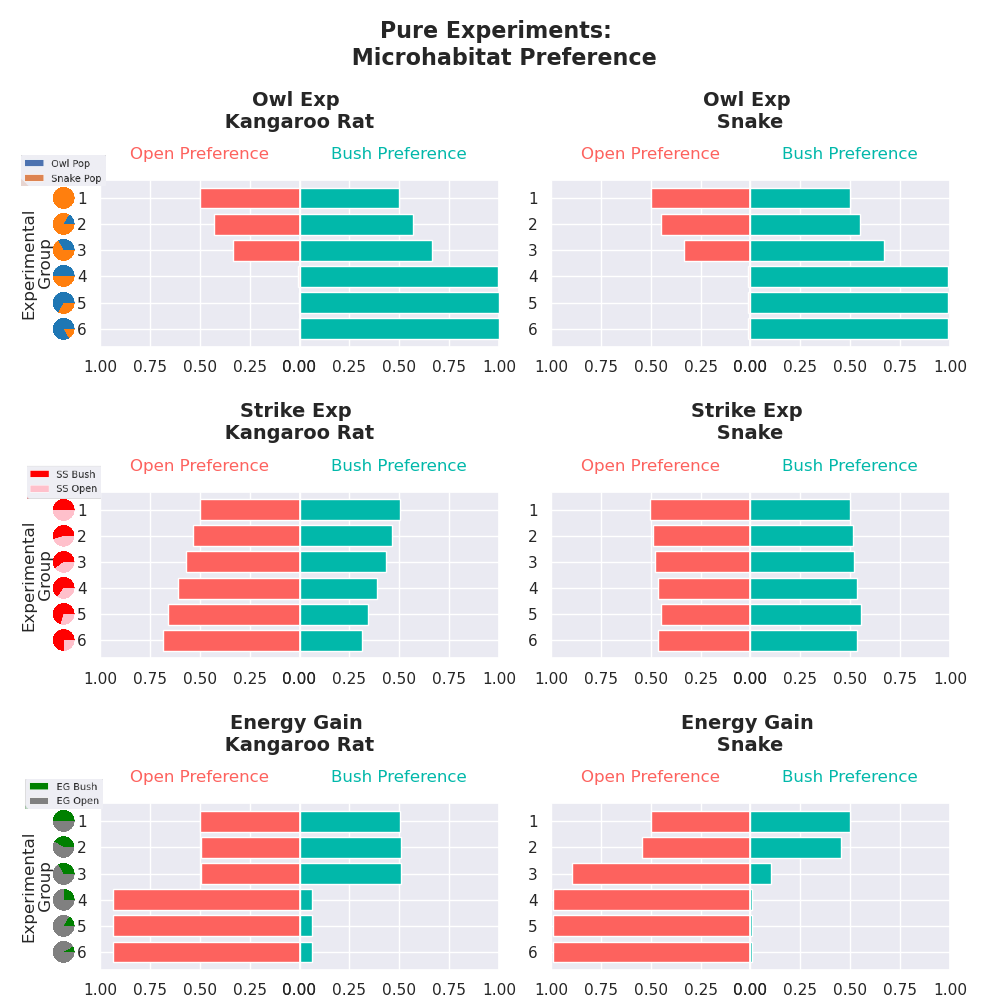

In [7]:
## working fig###
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import SubplotSpec
sns.set()
exps=['owl_exp_pure','owl_exp_pure',
      'strike_exp_pure','strike_exp_pure',
      'energy_gain_pure','energy_gain_pure',]


font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'

title0 = 'Open Preference'
title1 = 'Bush Preference'

rows = 3
cols = 2

fig = plt.figure(figsize=(10, 10))
# grid for pairs of subplots
grid = plt.GridSpec(rows, cols)
grid.update(left=0.1, top=0.82,bottom=0.03,right=0.95,wspace=.13,hspace=.87)


for i,exp in enumerate(exps):
    # create fake subplot just to title pair of subplots
    fake = fig.add_subplot(grid[i])
    data=get_data(exp)
    index = data.index
    column0 = data['krat_open']
    column1 = data['krat_bush']
    #  '\n' is important
    if (i % 2)==0:
        fake.set_title(f'{format_title(exp,remove_exp_type=True)}\n Kangaroo Rat \n\n', fontweight='semibold', size=14)
        column0 = data['krat_open']
        column1 = data['krat_bush']
    else:
        fake.set_title(f'{format_title(exp,remove_exp_type=True)}\n Snake \n\n', fontweight='semibold', size=14)
        column0 = data['snake_open']
        column1 = data['snake_bush']
    fake.set_axis_off()

    # create subgrid for two subplots without space between them
    # <https://matplotlib.org/2.0.2/users/gridspec.html>
    gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[i], wspace=0)

    # real subplot #1
    ax = fig.add_subplot(gs[0])
    ax.set_title(title0, fontsize=12, pad=15, color=color_red, **hfont)
    ax.barh(index, column0, align='center', color=color_red, zorder=10)
    ax.set(xlim=(0,1))
    ax.invert_xaxis()
    # hide ticks and labels
    #ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

    # real subplot #2
    ax2 = fig.add_subplot(gs[1], sharey=ax)
    ax2.barh(index, column1, align='center', color=color_blue, zorder=10)
    ax2.set_title(title1, fontsize=12, pad=15, color=color_blue, **hfont)
    ax2.invert_yaxis()
    # hide ticks and labels
    ax2.tick_params(left=False, labelleft=False)
    ax2.set(xlim=(0,1))
    if exp in ['owl_exp_pure','owl_exp_mixed'] and (i % 2)==0:
        for j in range(1,7):
            ax.set(ylabel = "Experimental\n Group \n")
            name = 'owl_figure_label_{}'.format(j)
            offset_image(j, name, ax2,zoom=0.08,xval=-170)
            get_legend(abrev_name='owl',coord=0,ax=ax2,zoom=0.5,x=-170,y=20)
    elif exp in ['strike_exp_pure','strike_exp_mixed'] and (i % 2)==0:
        for j in range(1,7):
            ax.set(ylabel = "Experimental\n Group \n")
            name = 'strike_success_figure_label_{}'.format(j)
            offset_image(j, name, ax2,zoom=0.08,xval=-170)
            get_legend(abrev_name='ss',coord=0,ax=ax2,zoom=0.5,x=-170,y=20)
    elif exp in ['energy_gain_pure','energy_gain_mixed'] and (i % 2)==0:
        for j in range(1,7):
            ax.set(ylabel = "Experimental\n Group \n")
            name = 'energy_gain_figure_label_{}'.format(j)
            offset_image(j, name, ax2,zoom=0.08,xval=-170)
            get_legend(abrev_name='energy_gain',coord=0,ax=ax2,zoom=0.5,x=-170,y=20)
    

fig.patch.set_facecolor('white')
fig.suptitle('Pure Experiments: \n Microhabitat Preference', fontweight='bold', size=16)
plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/pure_mh_pref_grid_032222.png')
#fig.tight_layout()

<IPython.core.display.Javascript object>


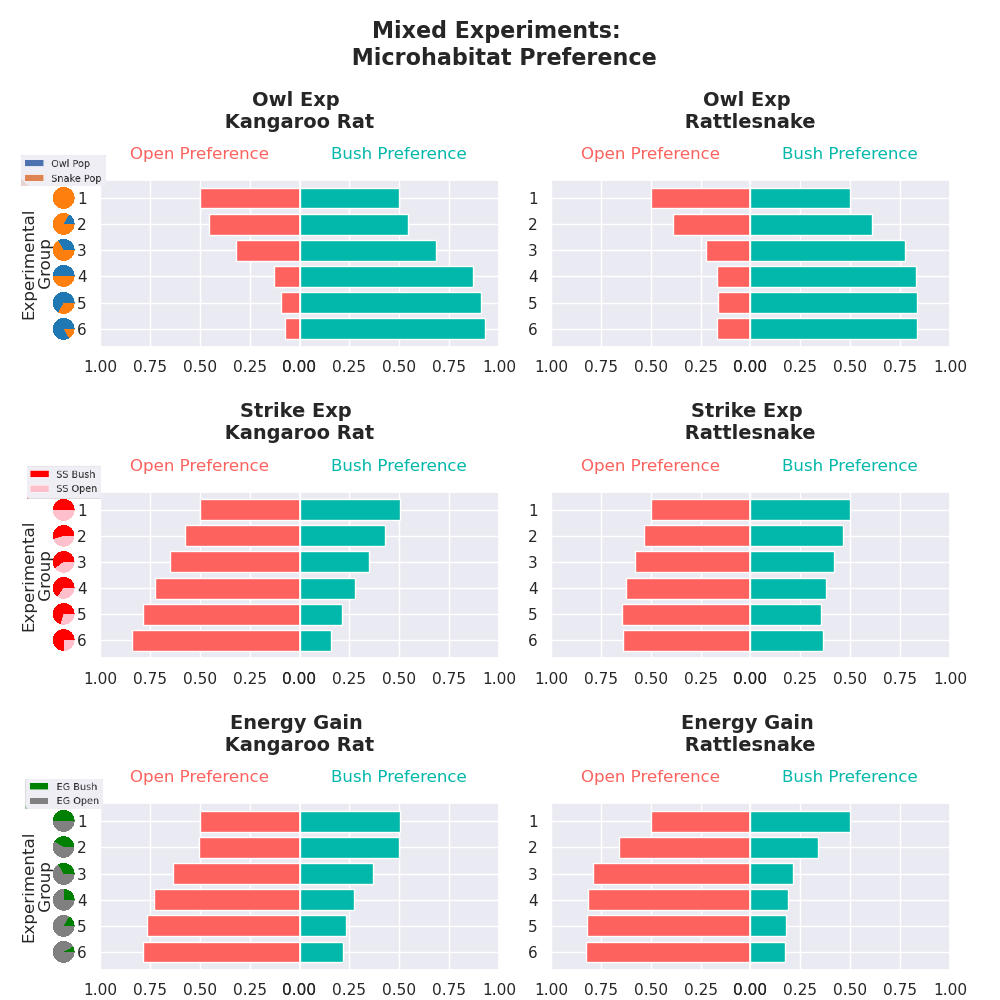

In [15]:
## working fig###
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import SubplotSpec
sns.set()
exps=['owl_exp_mixed','owl_exp_mixed',
      'strike_exp_mixed','strike_exp_mixed',
      'energy_gain_mixed','energy_gain_mixed',]


font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'

title0 = 'Open Preference'
title1 = 'Bush Preference'

rows = 3
cols = 2

fig = plt.figure(figsize=(10, 10))
# grid for pairs of subplots
grid = plt.GridSpec(rows, cols)
grid.update(left=0.1, top=0.82,bottom=0.03,right=0.95,wspace=.13,hspace=.87)


for i,exp in enumerate(exps):
    # create fake subplot just to title pair of subplots
    fake = fig.add_subplot(grid[i])
    data=get_data(exp)
    index = data.index
    column0 = data['krat_open']
    column1 = data['krat_bush']
    #  '\n' is important
    if (i % 2)==0:
        fake.set_title(f'{format_title(exp,remove_exp_type=True)}\n Kangaroo Rat \n\n', fontweight='semibold', size=14)
        column0 = data['krat_open']
        column1 = data['krat_bush']
    else:
        fake.set_title(f'{format_title(exp,remove_exp_type=True)}\n Rattlesnake \n\n', fontweight='semibold', size=14)
        column0 = data['snake_open']
        column1 = data['snake_bush']
    fake.set_axis_off()

    # create subgrid for two subplots without space between them
    # <https://matplotlib.org/2.0.2/users/gridspec.html>
    gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[i], wspace=0)

    # real subplot #1
    ax = fig.add_subplot(gs[0])
    ax.set_title(title0, fontsize=12, pad=15, color=color_red, **hfont)
    ax.barh(index, column0, align='center', color=color_red, zorder=10)
    ax.set(xlim=(0,1))
    ax.invert_xaxis()
    # hide ticks and labels
    #ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

    # real subplot #2
    ax2 = fig.add_subplot(gs[1], sharey=ax)
    ax2.barh(index, column1, align='center', color=color_blue, zorder=10)
    ax2.set_title(title1, fontsize=12, pad=15, color=color_blue, **hfont)
    ax2.invert_yaxis()
    # hide ticks and labels
    ax2.tick_params(left=False, labelleft=False)
    ax2.set(xlim=(0,1))
    if exp in ['owl_exp_pure','owl_exp_mixed'] and (i % 2)==0:
        for j in range(1,7):
            ax.set(ylabel = "Experimental\n Group \n")
            name = 'owl_figure_label_{}'.format(j)
            offset_image(j, name, ax2,zoom=0.08,xval=-170)
            get_legend(abrev_name='owl',coord=0,ax=ax2,zoom=0.5,x=-170,y=20)
    elif exp in ['strike_exp_pure','strike_exp_mixed'] and (i % 2)==0:
        for j in range(1,7):
            ax.set(ylabel = "Experimental\n Group \n")
            name = 'strike_success_figure_label_{}'.format(j)
            offset_image(j, name, ax2,zoom=0.08,xval=-170)
            get_legend(abrev_name='ss',coord=0,ax=ax2,zoom=0.5,x=-170,y=20)
    elif exp in ['energy_gain_pure','energy_gain_mixed'] and (i % 2)==0:
        for j in range(1,7):
            ax.set(ylabel = "Experimental\n Group \n")
            name = 'energy_gain_figure_label_{}'.format(j)
            offset_image(j, name, ax2,zoom=0.08,xval=-170)
            get_legend(abrev_name='energy_gain',coord=0,ax=ax2,zoom=0.5,x=-170,y=20)
    

fig.patch.set_facecolor('white')
fig.suptitle('Mixed Experiments: \n Microhabitat Preference', fontweight='bold', size=16)
plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/mixed_mh_pref_grid_032222.png')
#fig.tight_layout()

In [6]:
bp_df.head(10)

,figure_label,krat_bush,snake_bush,krat_open,snake_open
0,1,0.499648,0.499972,-0.500352,-0.500028
1,2,0.570157,0.549847,-0.429843,-0.450153
2,3,0.665595,0.667925,-0.334405,-0.332075
3,4,0.992277,0.989885,-0.007723,-0.010115
4,5,0.998328,0.989892,-0.001672,-0.010108
5,6,0.999448,0.989853,-0.000552,-0.010147


In [3]:
def get_chart(name):
    path = "/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/yaxis_labels/{}.png".format(name)
    im = plt.imread(path)
    return im


def offset_image(coord, name, ax, zoom=0.15):
    img = get_chart(name)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(im, (0, coord-1),  xybox=(-30., 0), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)
    
def get_legend(abrev_name,coord,ax,zoom=1):
    path = "/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/Legends/{}_legend.png".format(abrev_name)
    im = plt.imread(path)
    im = OffsetImage(im, zoom=zoom)
    ab = AnnotationBbox(im, (0, 0),  xybox=(0, 100), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)

In [49]:
temp = temp_data(df=result,filter_val='owl_exp_pure')
temp.head()

,exp_name,sim_id,exp,org,count_str_flip,mean_strategy_flip_time,std_strategy_flip_time,var_strategy_flip_time,mean_magnitude_of_strategy_flip,std_magnitude_of_strategy_flip,var_magnitude_of_strategy_flip,data_type,mean_bush_pref,figure_label
0,owl_exp_pure,06028c5bc0bb4674a7d322d9ac32ed5e,experiment1,krat,356,16.833803,12.288573,151.009024,0.843390,0.360106,0.129677,krat,0.514374,1
1,owl_exp_pure,06028c5bc0bb4674a7d322d9ac32ed5e,experiment1,snake,373,2.663978,1.234060,1.522904,0.887674,0.263518,0.069442,snake,0.494487,1
2,owl_exp_pure,078a550708c94ad589f54acb02b8b55a,experiment1,krat,385,15.484375,10.767651,115.942314,0.805410,0.393076,0.154509,krat,0.547678,1
3,owl_exp_pure,078a550708c94ad589f54acb02b8b55a,experiment1,snake,383,2.591623,1.096754,1.202869,0.909786,0.211419,0.044698,snake,0.463121,1
4,owl_exp_pure,0ebf538877ac46fda69541db6a494fa0,experiment1,krat,372,16.123989,10.884938,118.481882,0.852848,0.351398,0.123480,krat,0.504739,1


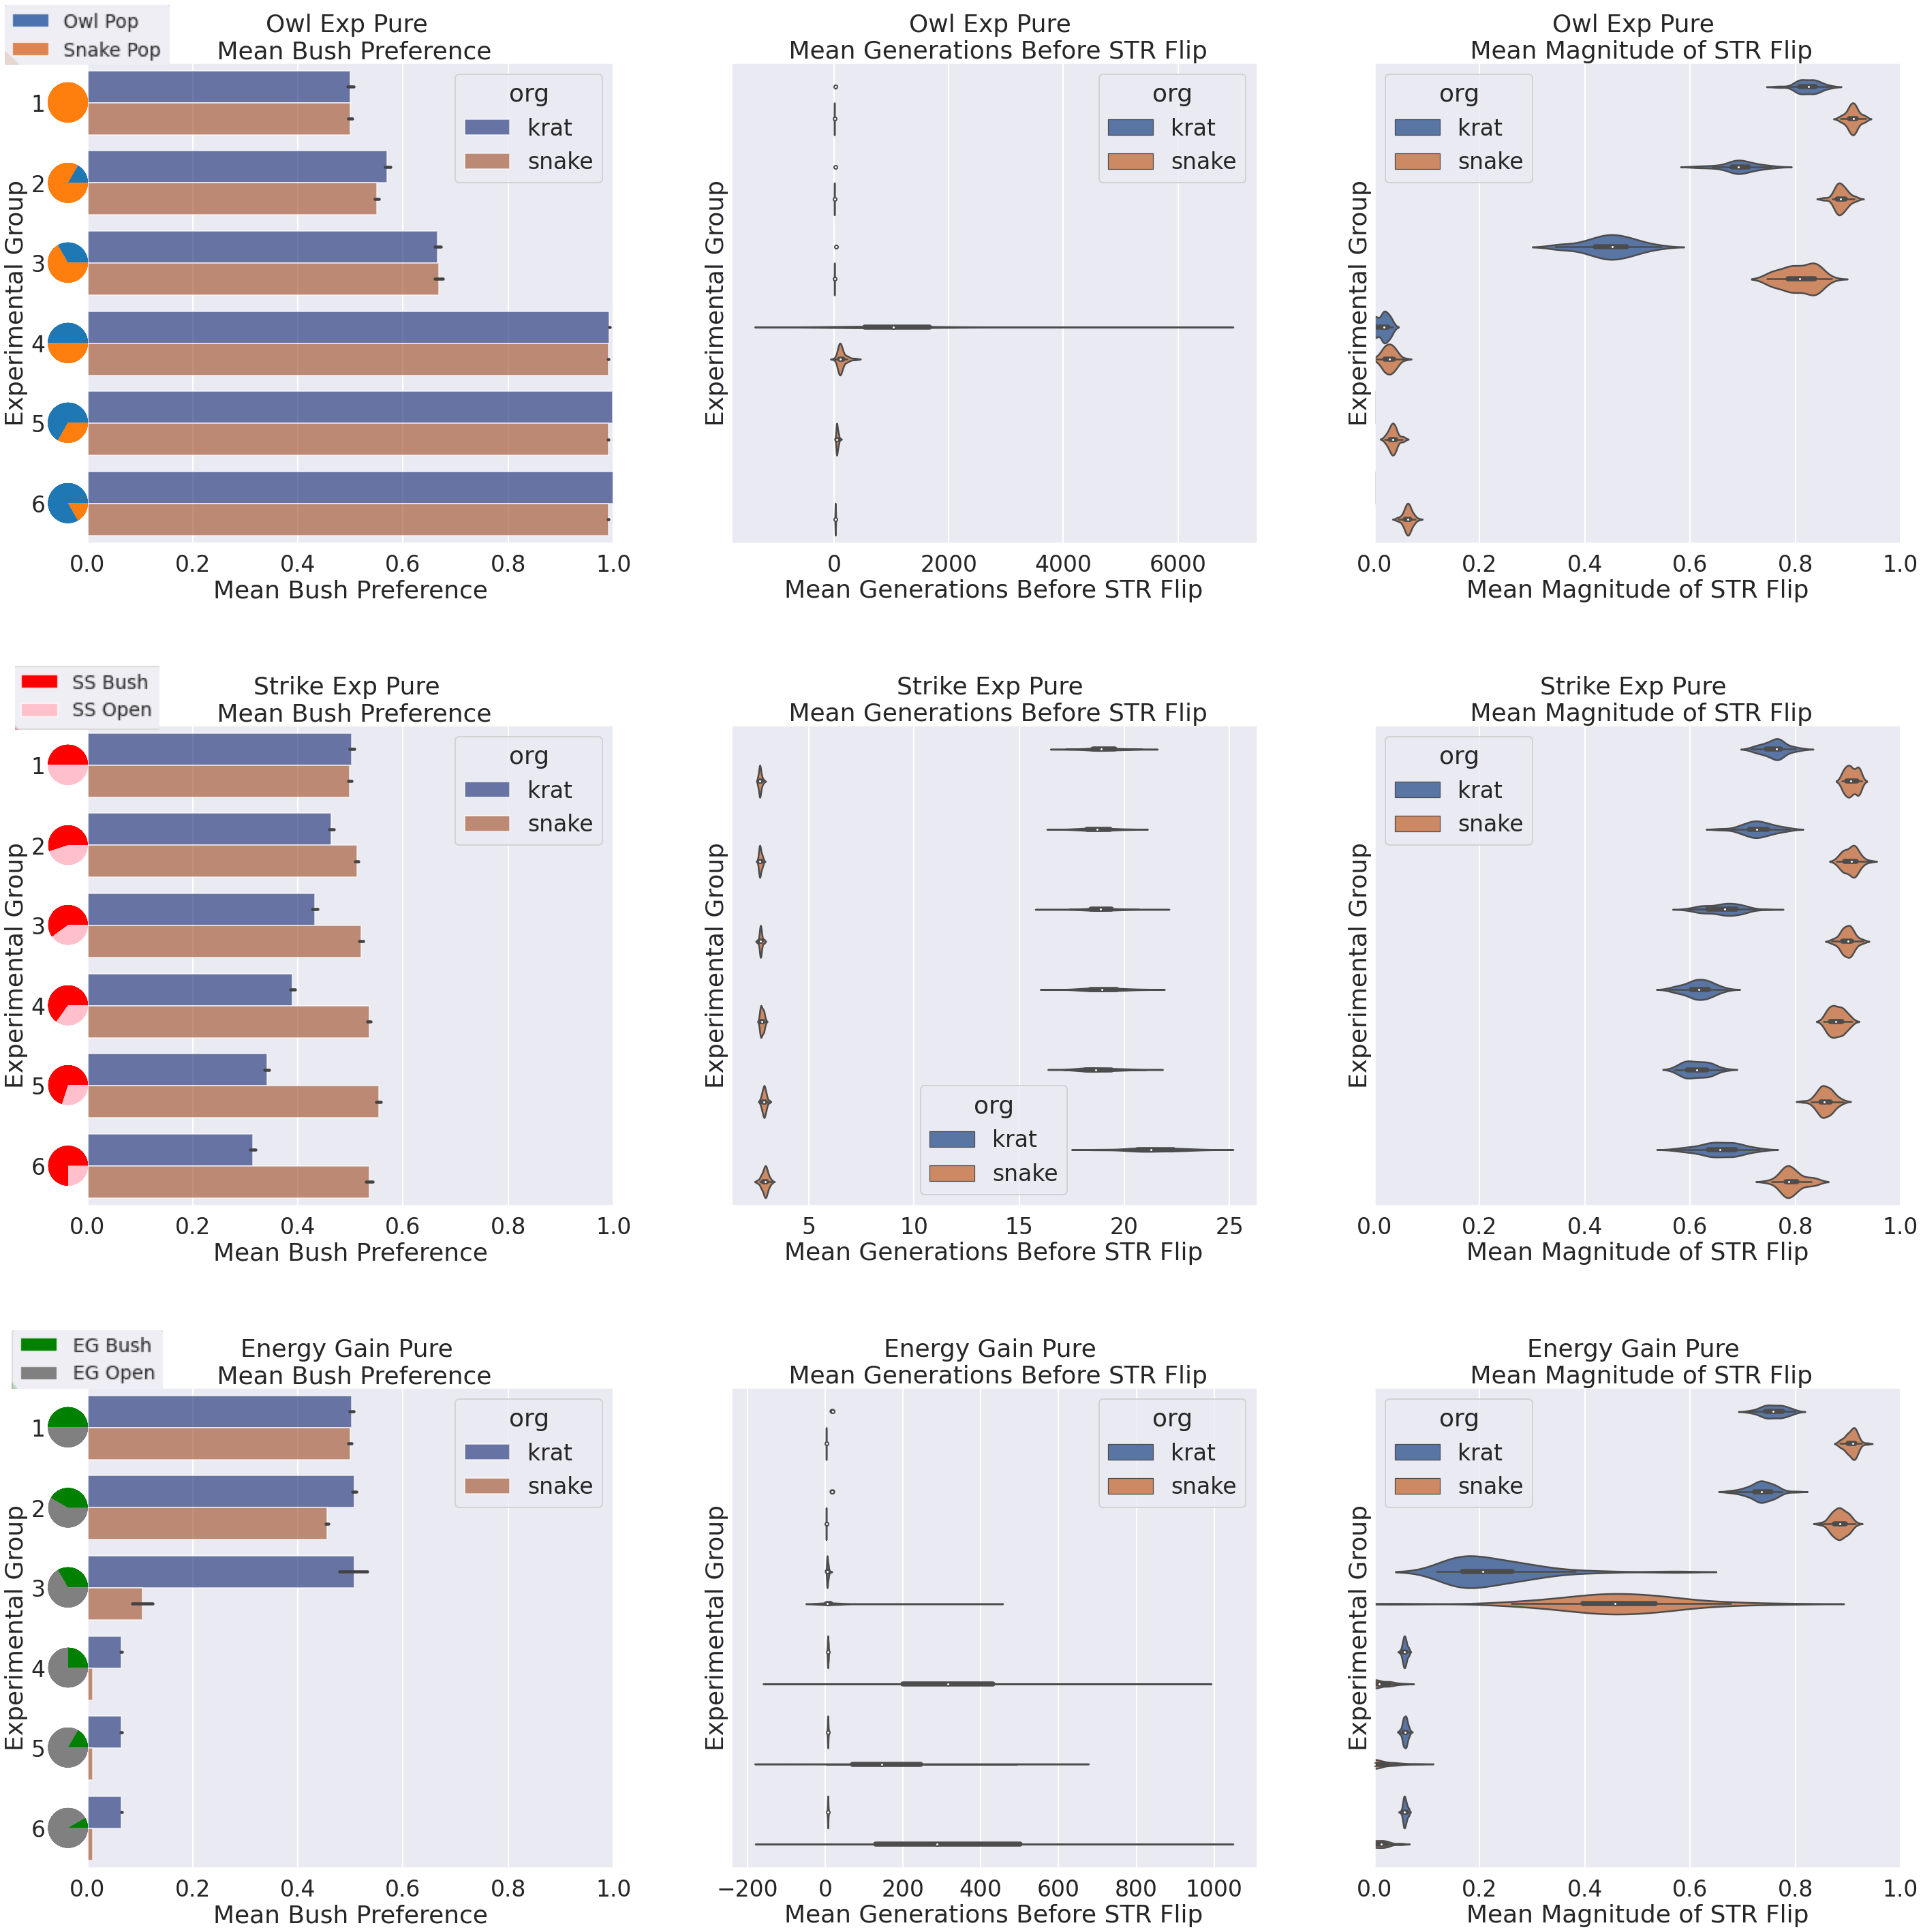

In [96]:
#######################
##### Official Chart ##
#######################
pure_exps = ['owl_exp_pure','strike_exp_pure','energy_gain_pure']

fig, axes = plt.subplots(len(pure_exps), 3, sharex=False,sharey=True, figsize=(42,42))



for i, title in enumerate(pure_exps):
    temp = temp_data(df=result,filter_val=title)
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
    g0 = sns.barplot(
            ax=axes[i,0], data=temp, 
            x="mean_bush_pref", y="figure_label", hue="org",
            ci=95, palette="dark", alpha=.6
        ).set(title='{} \n Mean Bush Preference'.format(format_title(title)),
              ylabel = "Experimental Group",
              xlabel = "Mean Bush Preference",
              xlim=(0, 1))
    axes[i,0].tick_params(axis='y', which='major', pad=50)
    if title in ['owl_exp_pure','owl_exp_mixed']:
        for j in range(1,7):
            name = 'owl_figure_label_{}'.format(j)
            offset_image(j, name, axes[i,0],zoom=0.3)
    elif title in ['strike_exp_pure','strike_exp_mixed']:
        for j in range(1,7):
            name = 'strike_success_figure_label_{}'.format(j)
            offset_image(j, name, axes[i,0],zoom=0.3)
    elif title in ['energy_gain_pure','energy_gain_mixed']:
        for j in range(1,7):
            name = 'energy_gain_figure_label_{}'.format(j)
            offset_image(j, name, axes[i,0],zoom=0.3)
    get_legend(abrev_name='owl',coord=0,ax=axes[0,0],zoom=2)
    get_legend(abrev_name='ss',coord=0,ax=axes[1,0],zoom=2)
    get_legend(abrev_name='energy_gain',coord=0,ax=axes[2,0],zoom=2)
    g1 = sns.violinplot(ax=axes[i,1],
                        x="mean_strategy_flip_time", y="figure_label",
                        hue="org", data=temp).set(title='{} \n Mean Generations Before STR Flip'.format(format_title(title)),
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Generations Before STR Flip")
    g2 = sns.violinplot(ax=axes[i,2],
                        x="mean_magnitude_of_strategy_flip", y="figure_label",
                        hue="org", data=temp).set(title='{} \n Mean Magnitude of STR Flip'.format(format_title(title)),
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Magnitude of STR Flip",
                                                  xlim=(0, 1))
    
    #height = .01
    #fig.figimage(eg_legend, 0, fig.bbox.ymax - height)


  

# A JointGrid


#gs.update(top=0.7)
fig.tight_layout(pad=3.0)
#plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/mh_pref_grid.png')
plt.show()
# https://stackoverflow.com/questions/69800347/bidirectional-bar-plot-in-python-how-to-remove-all-background-colours

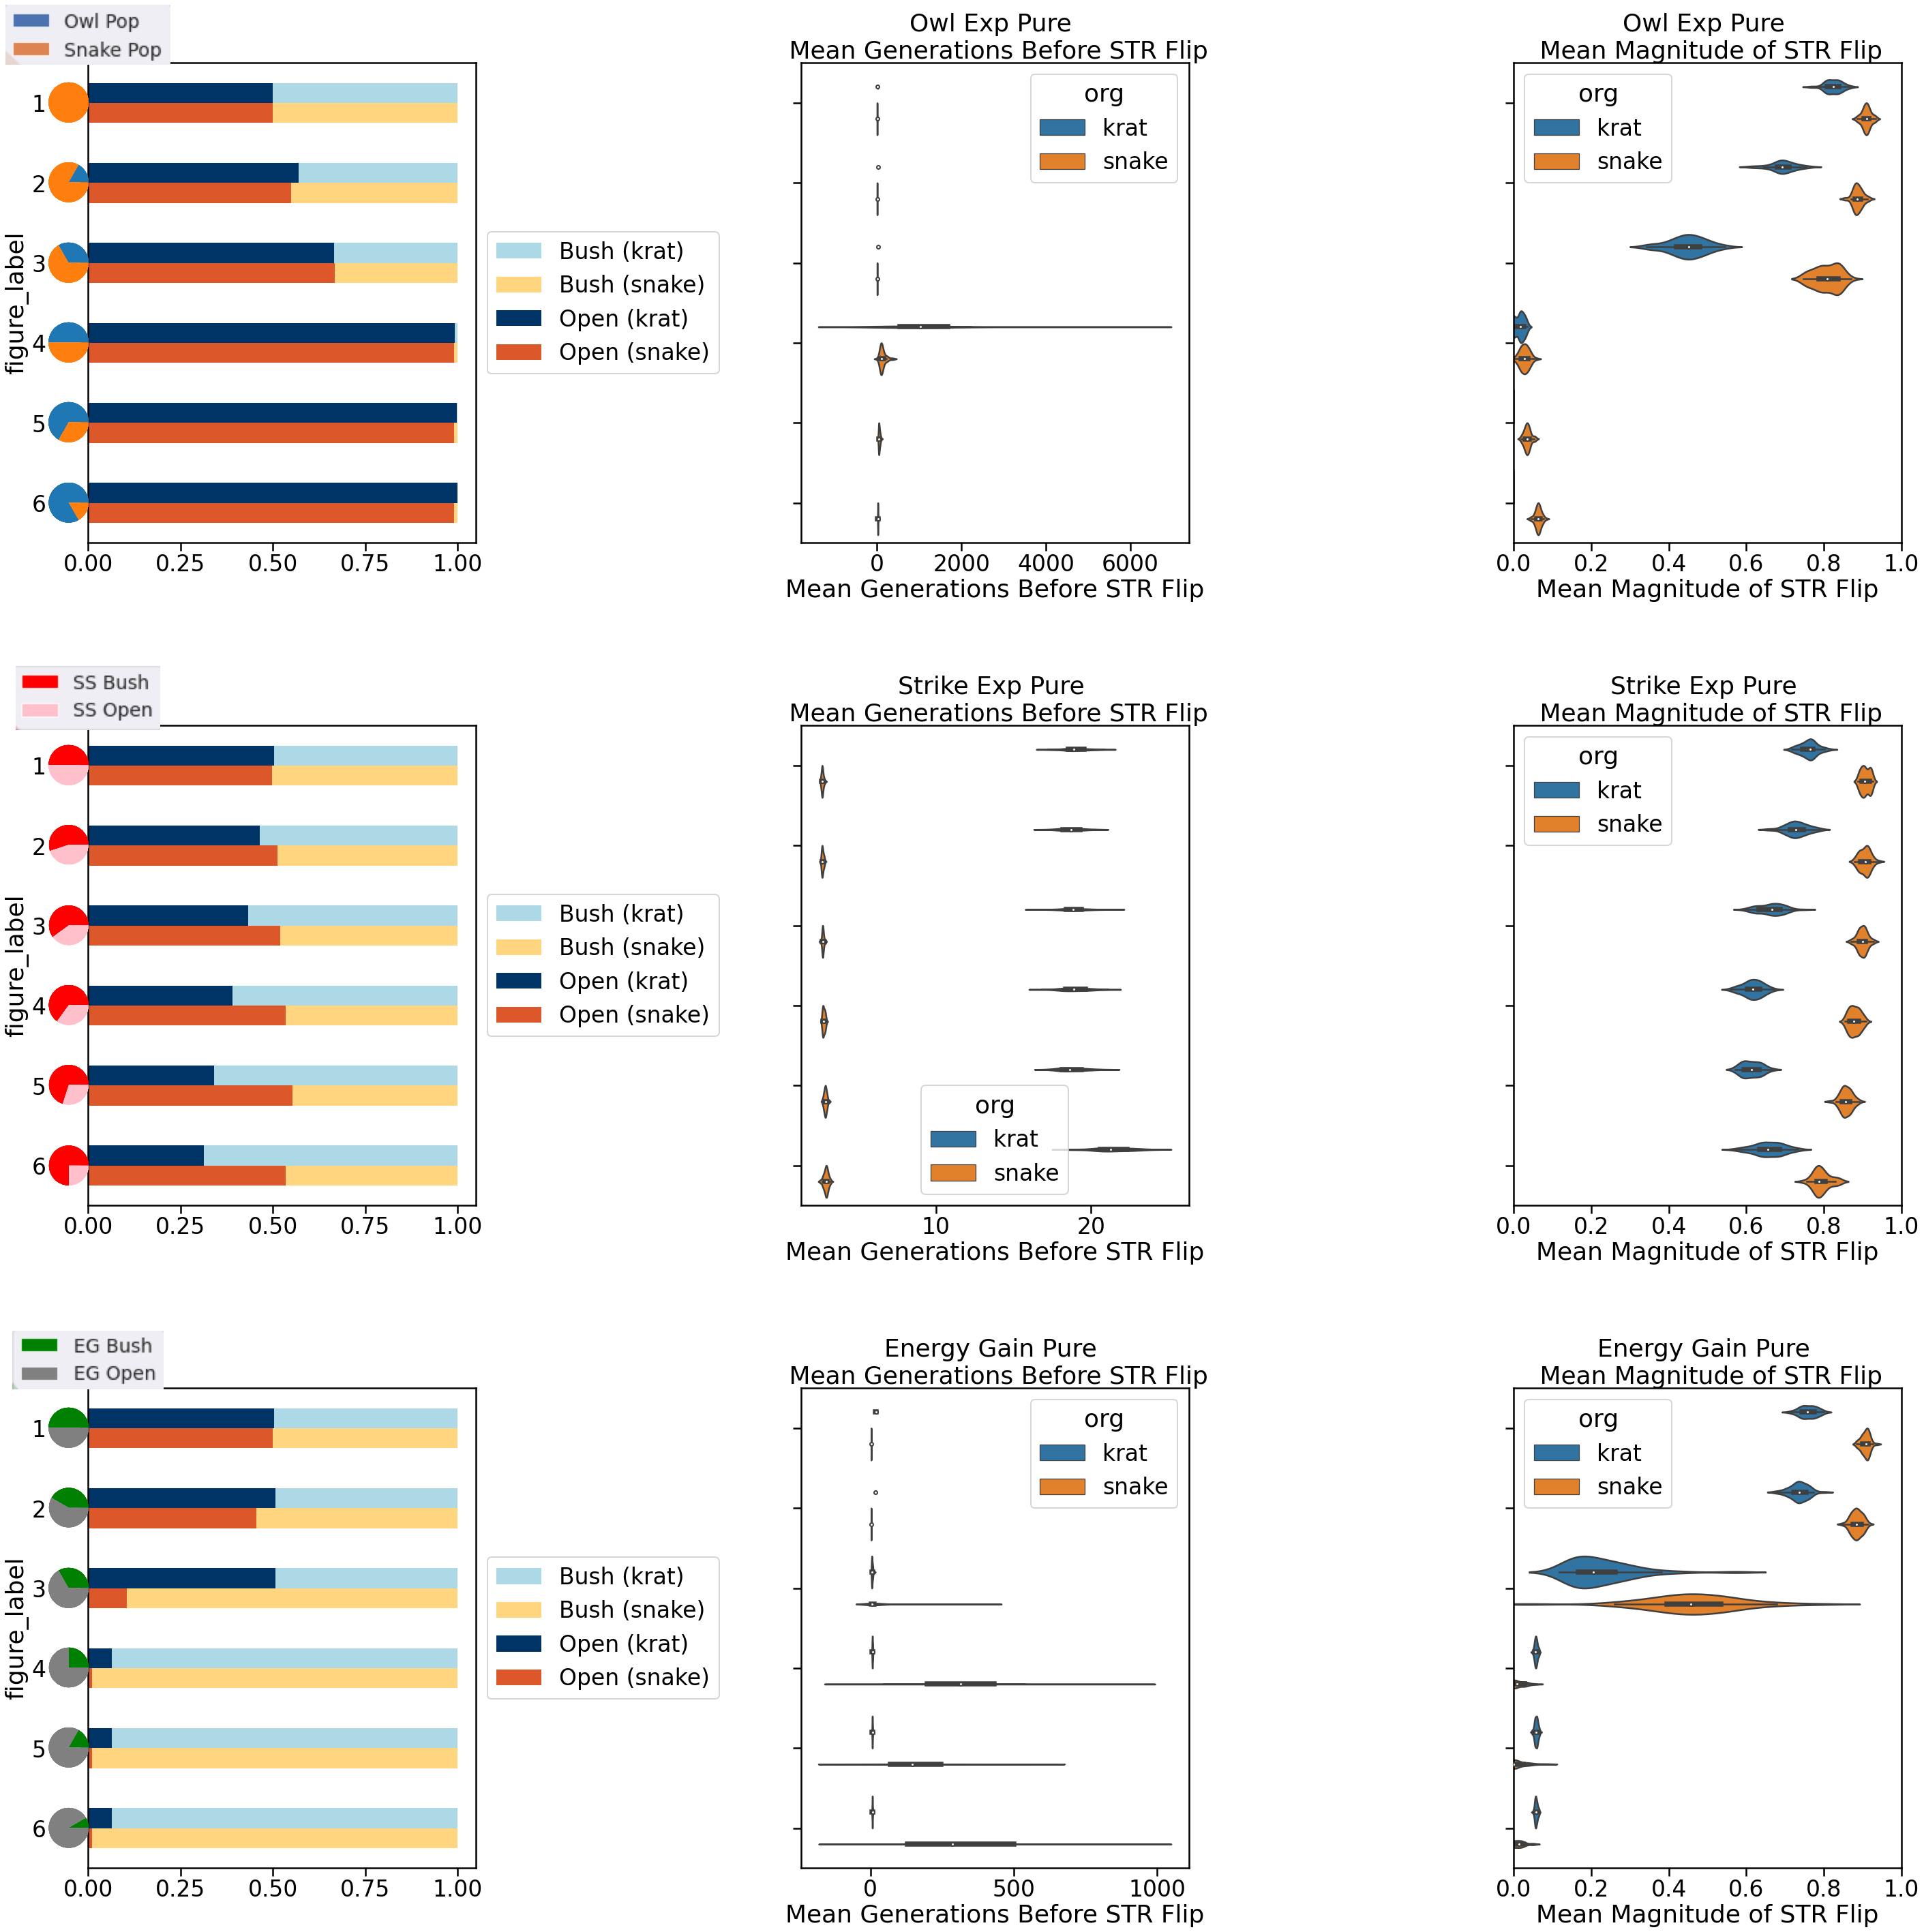

In [61]:
#######################
##### UnOfficial Chart 2 ##
#######################
pure_exps = ['owl_exp_pure','strike_exp_pure','energy_gain_pure']

fig, axes = plt.subplots(len(pure_exps), 3, sharex=False,sharey=True, figsize=(42,42))

colors = [
         '#FFD580', #light Orange
         '#ADD8E6', #light blue
         '#DC582A', # Dark Orange
         '#003366', #Dark Blue
         ] 

for i, title in enumerate(pure_exps):
    temp = temp_data(df=result,filter_val=title)
    bar_data=format_bar_chart_data(temp=temp)
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
    # Bar Chart
    (bar_data['Bush']+bar_data['Open']).plot(kind='barh', color=[colors[1], colors[0]], rot=0, ax=axes[i,0])
    (bar_data['Bush']).plot(kind='barh', color=[colors[3], colors[2]], rot=0, ax=axes[i,0])
    legend_labels = ['Bush (krat)','Open (krat)','Bush (snake)','ope']
    axes[i,0].legend(legend_labels,loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i,0].tick_params(axis='y', which='major', pad=50)
    if title in ['owl_exp_pure','owl_exp_mixed']:
        for j in range(1,7):
            name = 'owl_figure_label_{}'.format(j)
            offset_image(j, name, axes[i,0],zoom=0.3)
    elif title in ['strike_exp_pure','strike_exp_mixed']:
        for j in range(1,7):
            name = 'strike_success_figure_label_{}'.format(j)
            offset_image(j, name, axes[i,0],zoom=0.3)
    elif title in ['energy_gain_pure','energy_gain_mixed']:
        for j in range(1,7):
            name = 'energy_gain_figure_label_{}'.format(j)
            offset_image(j, name, axes[i,0],zoom=0.3)
    get_legend(abrev_name='owl',coord=0,ax=axes[0,0],zoom=2)
    get_legend(abrev_name='ss',coord=0,ax=axes[1,0],zoom=2)
    get_legend(abrev_name='energy_gain',coord=0,ax=axes[2,0],zoom=2)
    # Violin Plot 1
    g1 = sns.violinplot(ax=axes[i,1],
                        x="mean_strategy_flip_time", y="figure_label",
                        hue="org", data=temp).set(title='{} \n Mean Generations Before STR Flip'.format(format_title(title)),
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Generations Before STR Flip")
    g2 = sns.violinplot(ax=axes[i,2],
                        x="mean_magnitude_of_strategy_flip", y="figure_label",
                        hue="org", data=temp).set(title='{} \n Mean Magnitude of STR Flip'.format(format_title(title)),
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Magnitude of STR Flip",
                                                  xlim=(0, 1))
    
    #height = .01
    #fig.figimage(eg_legend, 0, fig.bbox.ymax - height)


  

# A JointGrid


#gs.update(top=0.7)
fig.tight_layout(pad=3.0)
plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/mh_pref_grid.png')
plt.show()


In [4]:
exps = result['exp_name'].unique()
# An lmplot


# fig, axes = plt.subplots(len(exps), 3, sharex=True,sharey=False, figsize=(18,36))

# for i, title in enumerate(exps):
#     temp = temp_data(df=result,filter_val=title)
#     g0 = sns.barplot(
#             ax=axes[i,0], data=temp, 
#             x='figure_label', y="mean_bush_pref", hue="org",
#             ci=95, palette="dark", alpha=.6
#         ).set(title='{} \n Mean Bush Preference'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Bush Preference",
#               ylim=(0, 1))
#     g1 = sns.violinplot(ax=axes[i,1],x='figure_label', y="mean_strategy_flip_time",hue="org", palette="dark", data=temp).set(title='{} \n Mean Generations Before STR Flip'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Generations Before STR Flip")
#     g2 = sns.violinplot(ax=axes[i,2],x='figure_label', y="mean_magnitude_of_strategy_flip", palette="dark", hue="org", data=temp).set(title='{} \n Mean Magnitude of STR Flip'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Magnitude of STR Flip",
#               ylim=(0, 1))

    

# # A JointGrid


# #gs.update(top=0.7)
# plt.savefig('results.png')
# plt.show()


In [5]:
exps = result['exp_name'].unique()
# An lmplot


# fig, axes = plt.subplots(len(exps), 4, sharex=True,sharey=False, figsize=(24,36))

# for i, title in enumerate(exps):
#     temp = temp_data(df=result,filter_val=title)
#     ##Initial condition figs
#     if title in ['owl_exp_pure','owl_exp_mixed']:
#         df_owl.set_index('figure_label').plot(ax=axes[i,0],kind='bar', stacked=True).set(
#             title='{} \n Initial Conditions'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Predators")
#     elif title in ['strike_exp_pure','strike_exp_mixed']:
#         df_ss.set_index('figure_label').plot(ax=axes[i,0],kind='bar', stacked=True).set(
#             title='{} \n Initial Conditions'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Strike Success Probability")
#     elif title in ['energy_gain_pure','energy_gain_mixed']:
#         df_eg.set_index('figure_label').plot(ax=axes[i,0],kind='bar', stacked=True).set(
#             title='{} \n Initial Conditions'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Energy Gain")
#     ## MHPREF
#     g1 = sns.barplot(
#             ax=axes[i,1], data=temp, 
#             x='figure_label', y="mean_bush_pref", hue="org",
#             ci=95, palette="dark", alpha=.6
#         ).set(title='{} \n Mean Bush Preference'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Bush Preference",
#               ylim=(0, 1))
#     ## Generations
#     g2 = sns.violinplot(ax=axes[i,2],x='figure_label', y="mean_strategy_flip_time",hue="org", palette="dark", data=temp).set(title='{} \n Mean Generations Before STR Flip'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Generations Before STR Flip")
#     #Magnitude
#     g3 = sns.violinplot(ax=axes[i,3],x='figure_label', y="mean_magnitude_of_strategy_flip", palette="dark", hue="org", data=temp).set(title='{} \n Mean Magnitude of STR Flip'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Magnitude of STR Flip",
#               ylim=(0, 1))

    

# # A JointGrid


# #gs.update(top=0.7)
# #plt.savefig('results_with_ic.png')
# plt.show()


In [48]:
#df_eg.head()
help(sns.set_context)

Help on function set_context in module seaborn.rcmod:

set_context(context=None, font_scale=1, rc=None)
    Set the plotting context parameters.
    
    This affects things like the size of the labels, lines, and other
    elements of the plot, but not the overall style. The base context
    is "notebook", and the other contexts are "paper", "talk", and "poster",
    which are version of the notebook parameters scaled by .8, 1.3, and 1.6,
    respectively.
    
    Parameters
    ----------
    context : dict, None, or one of {paper, notebook, talk, poster}
        A dictionary of parameters or the name of a preconfigured set.
    font_scale : float, optional
        Separate scaling factor to independently scale the size of the
        font elements.
    rc : dict, optional
        Parameter mappings to override the values in the preset seaborn
        context dictionaries. This only updates parameters that are
        considered part of the context definition.
    
    Examples
    

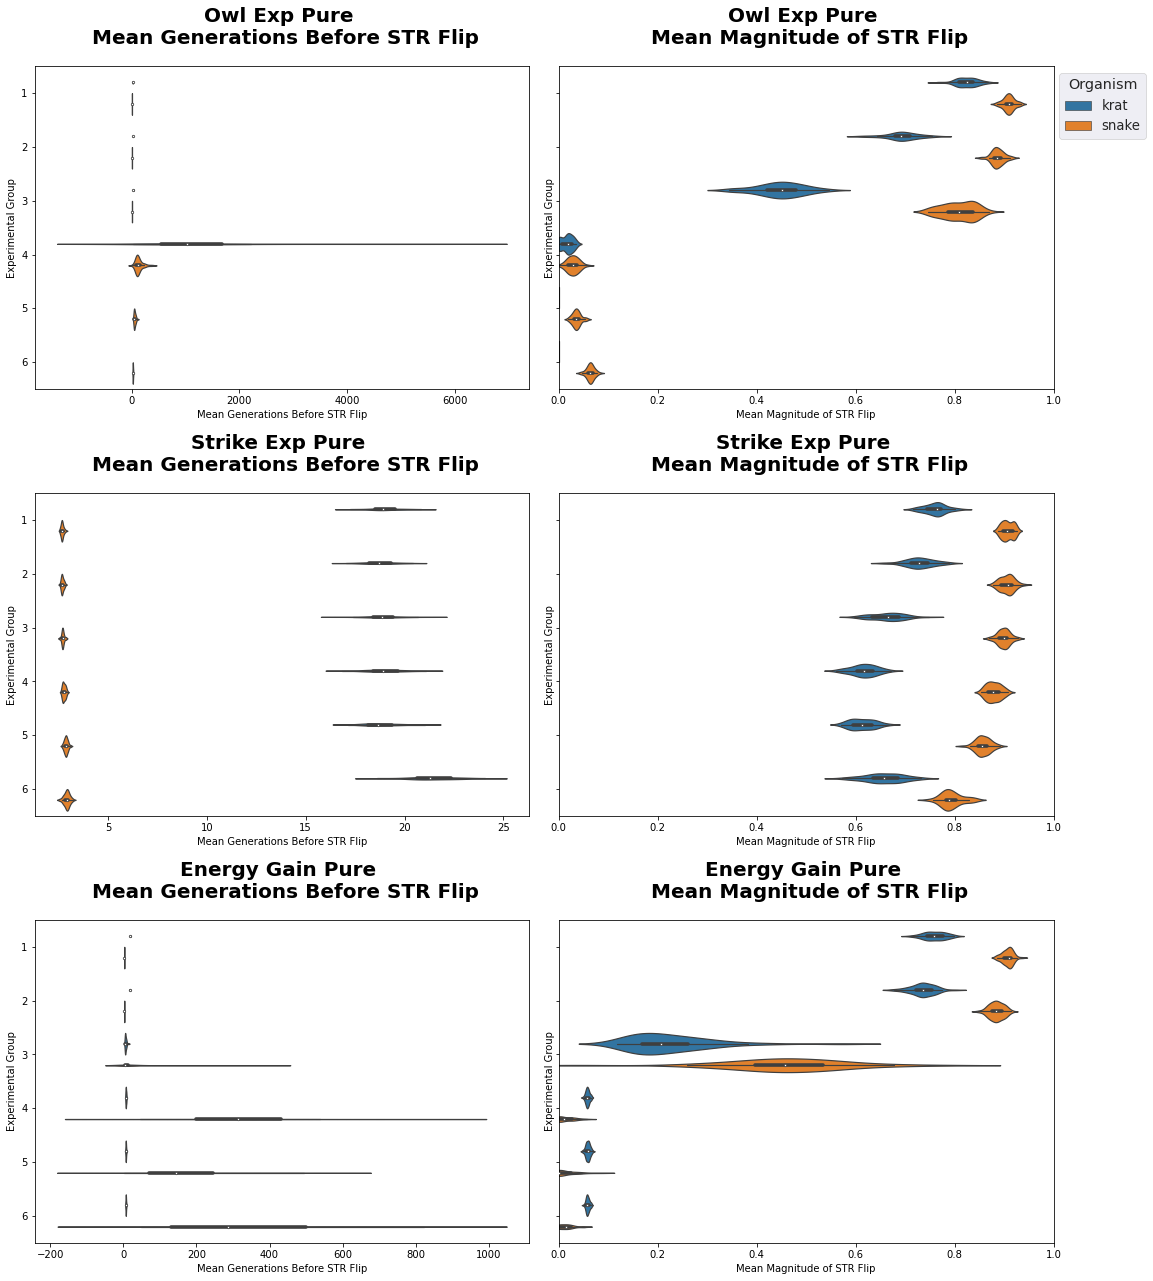

In [3]:
#######################
##### Official Chart ##
#######################
pure_exps = ['owl_exp_pure','strike_exp_pure','energy_gain_pure']

fig, axes = plt.subplots(len(pure_exps), 2, sharex=False,sharey=True, figsize=(16,18))

#sns.set(style="ticks")
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=1.5)

for i, title in enumerate(pure_exps):
    temp = temp_data(df=result,filter_val=title)
     
    g1 = sns.boxplot(ax=axes[i,0],
                        x="mean_strategy_flip_time", y="figure_label",
                        hue="org", data=temp, legend = False).set(
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Generations Before STR Flip")
    axes[i,0].set_title('{} \n Mean Generations Before STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.05)
    axes[i,0].legend_.remove()
    g2 = sns.violinplot(ax=axes[i,1],
                        x="mean_magnitude_of_strategy_flip", y="figure_label",
                        hue="org", data=temp, legend = False).set(
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Magnitude of STR Flip",
                                                  xlim=(0, 1))
    axes[i,1].set_title('{} \n Mean Magnitude of STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.05)
    if i==0:
        axes[i,1].legend(bbox_to_anchor=(1.2, 1),loc='upper right', title='Organism')
    else:
        axes[i,1].legend_.remove()
    
    
    #height = .01
    #fig.figimage(eg_legend, 0, fig.bbox.ymax - height)


 

# A JointGrid


#gs.update(top=0.7)
fig.tight_layout()

plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/pure_str_flip.png')
#plt.show()
# https://stackoverflow.com/questions/69800347/bidirectional-bar-plot-in-python-how-to-remove-all-background-colours

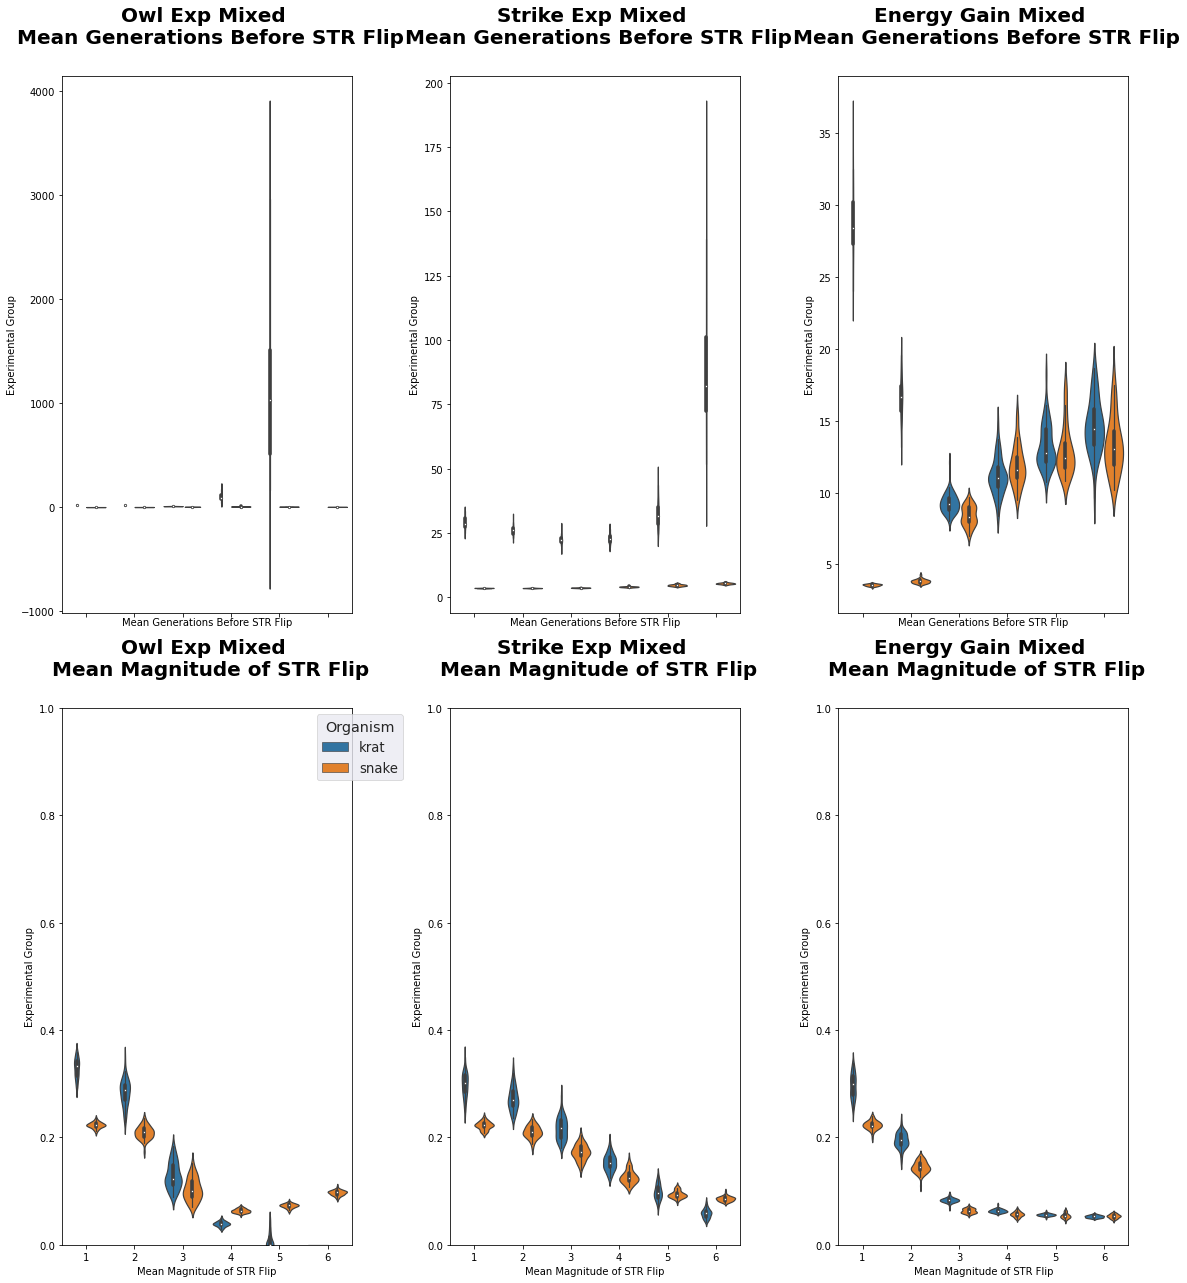

In [3]:
#######################
##### Official Chart ##
#######################
pure_exps = ['owl_exp_mixed','strike_exp_mixed','energy_gain_mixed']

fig, axes = plt.subplots(2, len(pure_exps), sharex=True,sharey=False, figsize=(16,18))

#sns.set(style="ticks")
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=1.5)

for i, title in enumerate(pure_exps):
    temp = temp_data(df=result,filter_val=title)
     
    g1 = sns.violinplot(ax=axes[0,i],
                        x="figure_label", y="mean_strategy_flip_time",
                        hue="org", data=temp, legend = False).set(
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Generations Before STR Flip")
    axes[0,i].set_title('{} \n Mean Generations Before STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.05)
    axes[0,i].legend_.remove()
    g2 = sns.violinplot(ax=axes[1,i],
                        x="figure_label", y="mean_magnitude_of_strategy_flip",
                        hue="org", data=temp, legend = False).set(
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Magnitude of STR Flip",
                                                  ylim=(0, 1))
    axes[1,i].set_title('{} \n Mean Magnitude of STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.05)
    if i==0:
        axes[1,i].legend(bbox_to_anchor=(1.2, 1),loc='upper right', title='Organism')
    else:
        axes[1,i].legend_.remove()
    
    
    #height = .01
    #fig.figimage(eg_legend, 0, fig.bbox.ymax - height)


 

# A JointGrid


#gs.update(top=0.7)
fig.tight_layout()

#plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/pure_str_flip.png')
plt.show()

In [5]:
result.head()

,exp_name,sim_id,exp,org,count_str_flip,mean_strategy_flip_time,std_strategy_flip_time,var_strategy_flip_time,mean_magnitude_of_strategy_flip,std_magnitude_of_strategy_flip,var_magnitude_of_strategy_flip,data_type,mean_bush_pref,figure_label
0,owl_exp_pure,06028c5bc0bb4674a7d322d9ac32ed5e,experiment1,krat,356,16.833803,12.288573,151.009024,0.843390,0.360106,0.129677,krat,0.514374,1
1,owl_exp_pure,06028c5bc0bb4674a7d322d9ac32ed5e,experiment1,snake,373,2.663978,1.234060,1.522904,0.887674,0.263518,0.069442,snake,0.494487,1
2,owl_exp_pure,078a550708c94ad589f54acb02b8b55a,experiment1,krat,385,15.484375,10.767651,115.942314,0.805410,0.393076,0.154509,krat,0.547678,1
3,owl_exp_pure,078a550708c94ad589f54acb02b8b55a,experiment1,snake,383,2.591623,1.096754,1.202869,0.909786,0.211419,0.044698,snake,0.463121,1
4,owl_exp_pure,0ebf538877ac46fda69541db6a494fa0,experiment1,krat,372,16.123989,10.884938,118.481882,0.852848,0.351398,0.123480,krat,0.504739,1


In [ ]:
bp_df = result.groupby(['exp_name','exp','org']).agg(
    # Get max of the duration column for each group
    Bush=pd.NamedAgg(column='mean_bush_pref', aggfunc='mean'),
#     exp_std_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='std'),
#     exp_se_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='sem')
    )

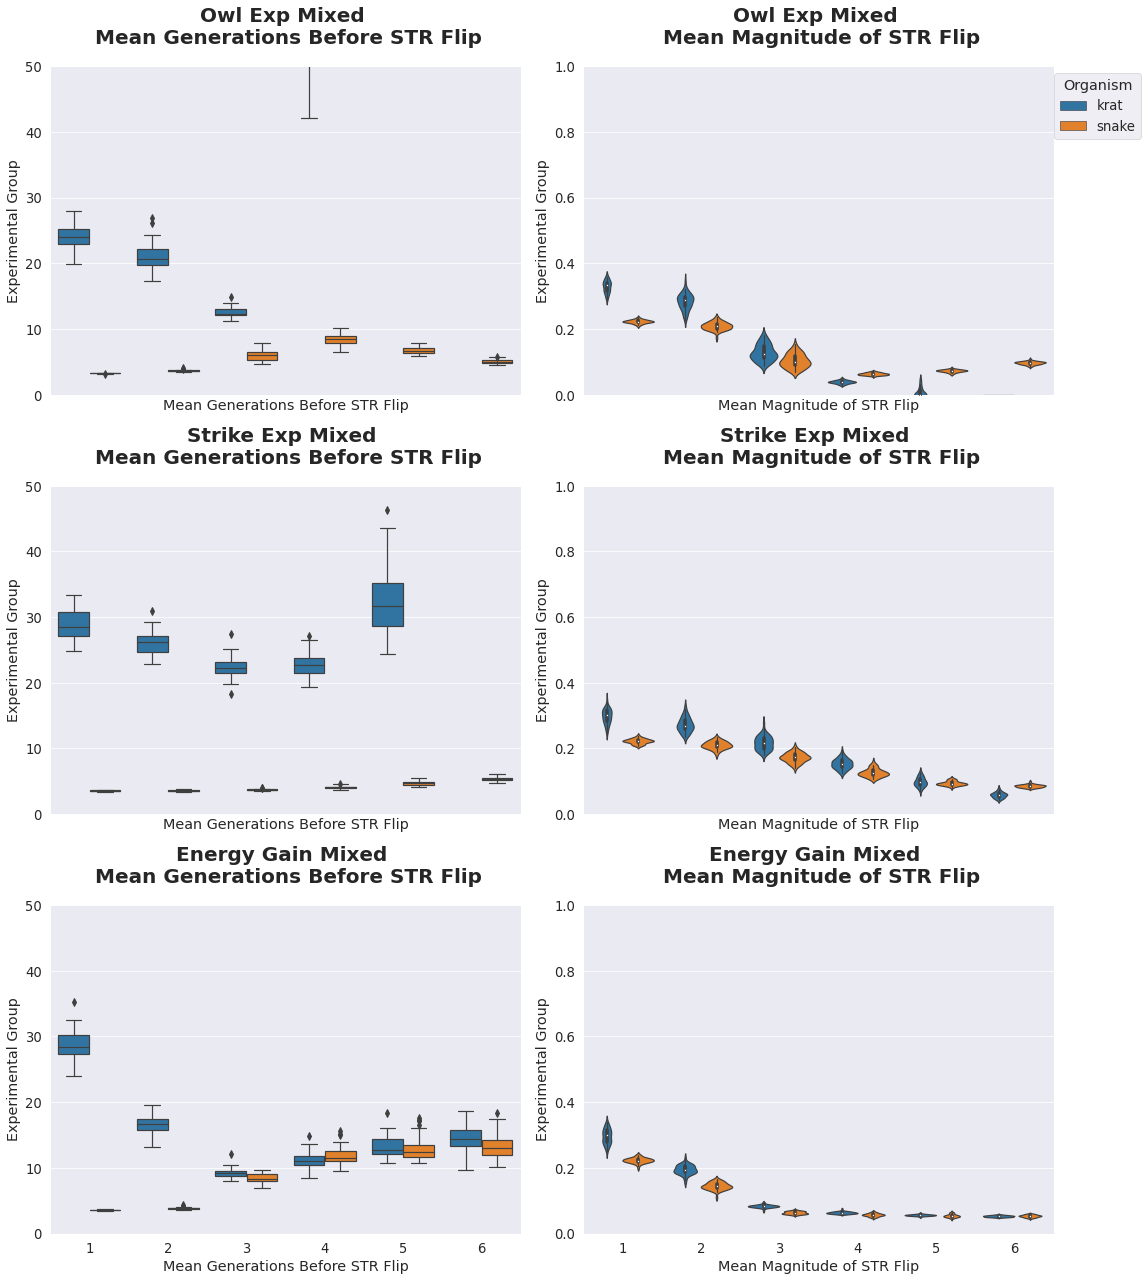

In [10]:
#######################
##### Official Chart ##
#######################
pure_exps = ['owl_exp_mixed','strike_exp_mixed','energy_gain_mixed']

fig, axes = plt.subplots(len(pure_exps), 2, sharex=True,sharey=False, figsize=(16,18))

#sns.set(style="ticks")
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=1.5)

for i, title in enumerate(pure_exps):
    temp = temp_data(df=result,filter_val=title)
     
    g1 = sns.boxplot(ax=axes[i,0],
                        x="figure_label", y="mean_strategy_flip_time",
                        hue="org", data=temp).set(
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Generations Before STR Flip",
                                                  ylim =(0,50))
    axes[i,0].set_title('{} \n Mean Generations Before STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.05)
    axes[i,0].legend_.remove()
    g2 = sns.violinplot(ax=axes[i,1],
                        x="figure_label", y="mean_magnitude_of_strategy_flip",
                        hue="org", data=temp, legend = False).set(
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Magnitude of STR Flip",
                                                  ylim=(0, 1))
    axes[i,1].set_title('{} \n Mean Magnitude of STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.05)
    if i==0:
        axes[i,1].legend(bbox_to_anchor=(1.2, 1),loc='upper right', title='Organism')
    else:
        axes[i,1].legend_.remove()
    
    
    #height = .01
    #fig.figimage(eg_legend, 0, fig.bbox.ymax - height)


 

# A JointGrid


#gs.update(top=0.7)
fig.tight_layout()

#plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/pure_str_flip.png')
plt.show()

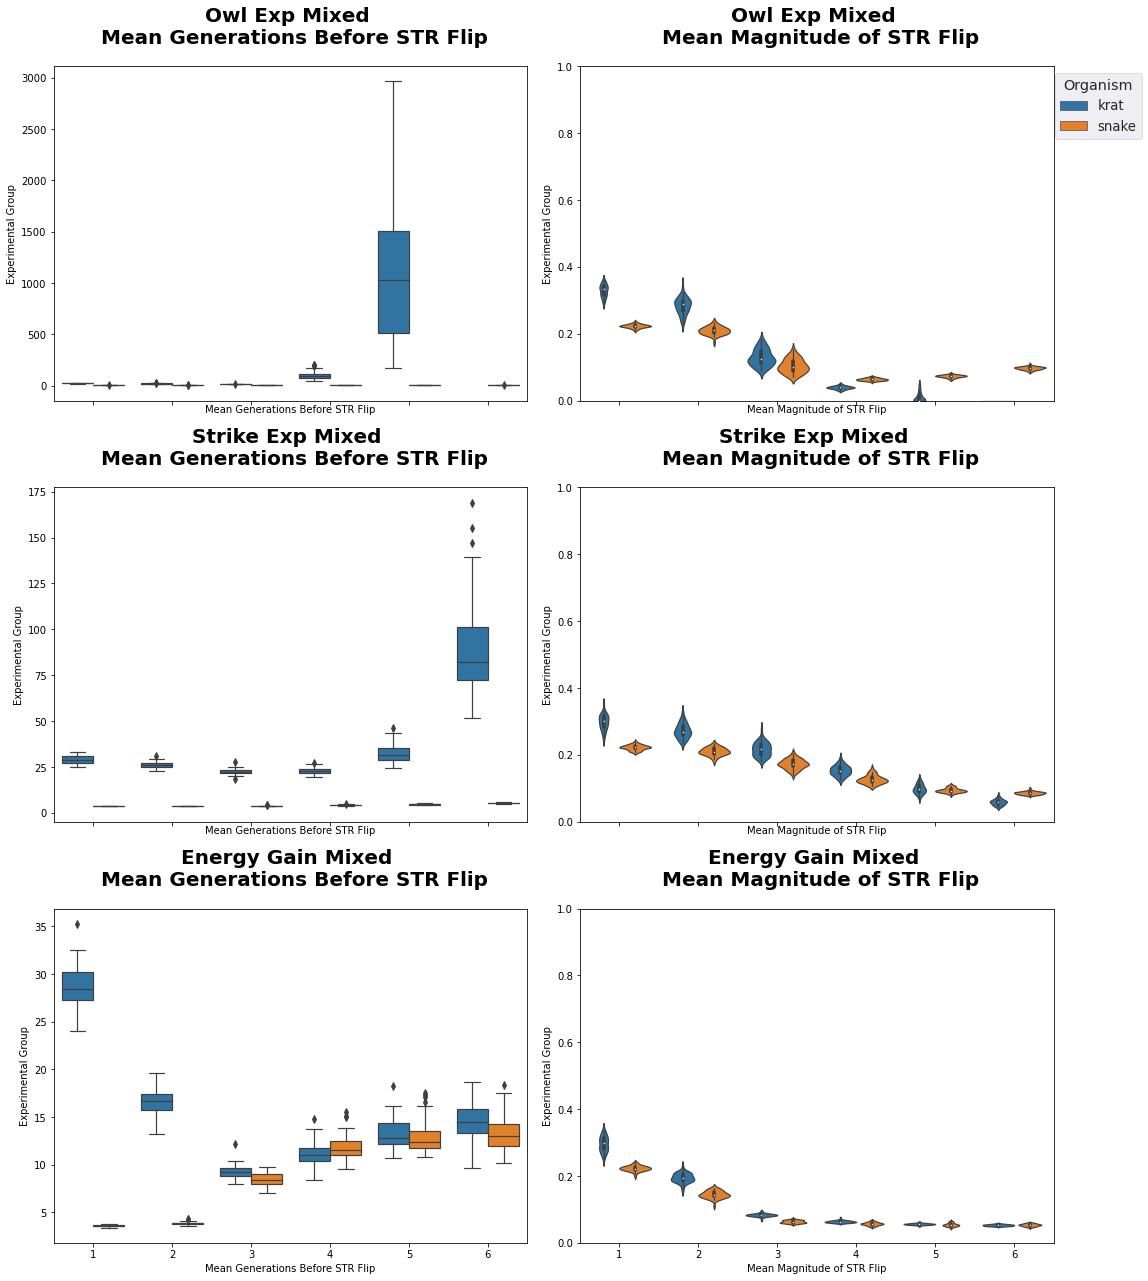

In [3]:
#######################
##### Official Chart ##
#######################
pure_exps = ['owl_exp_mixed','strike_exp_mixed','energy_gain_mixed']

fig, axes = plt.subplots(len(pure_exps), 2, sharex=True,sharey=False, figsize=(16,18))

#sns.set(style="ticks")
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=1.5)

for i, title in enumerate(pure_exps):
    temp = temp_data(df=result,filter_val=title)
    
     
    g1 = sns.boxplot(ax=axes[i,0],
                        x="figure_label", y="mean_strategy_flip_time",
                        hue="org", data=temp).set(
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Generations Before STR Flip")
    axes[i,0].set_title('{} \n Mean Generations Before STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.05)
    axes[i,0].legend_.remove()
    g2 = sns.violinplot(ax=axes[i,1],
                        x="figure_label", y="mean_magnitude_of_strategy_flip",
                        hue="org", data=temp, legend = False).set(
                                                  ylabel = "Experimental Group",
                                                  xlabel = "Mean Magnitude of STR Flip",
                                                  ylim=(0, 1))
    axes[i,1].set_title('{} \n Mean Magnitude of STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 20, 'fontweight':'bold'}, y =1.05)
    if i==0:
        axes[i,1].legend(bbox_to_anchor=(1.2, 1),loc='upper right', title='Organism')
    else:
        axes[i,1].legend_.remove()
    
    
    #height = .01
    #fig.figimage(eg_legend, 0, fig.bbox.ymax - height)


 

# A JointGrid


#gs.update(top=0.7)
fig.tight_layout()

#plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/pure_str_flip.png')
plt.show()

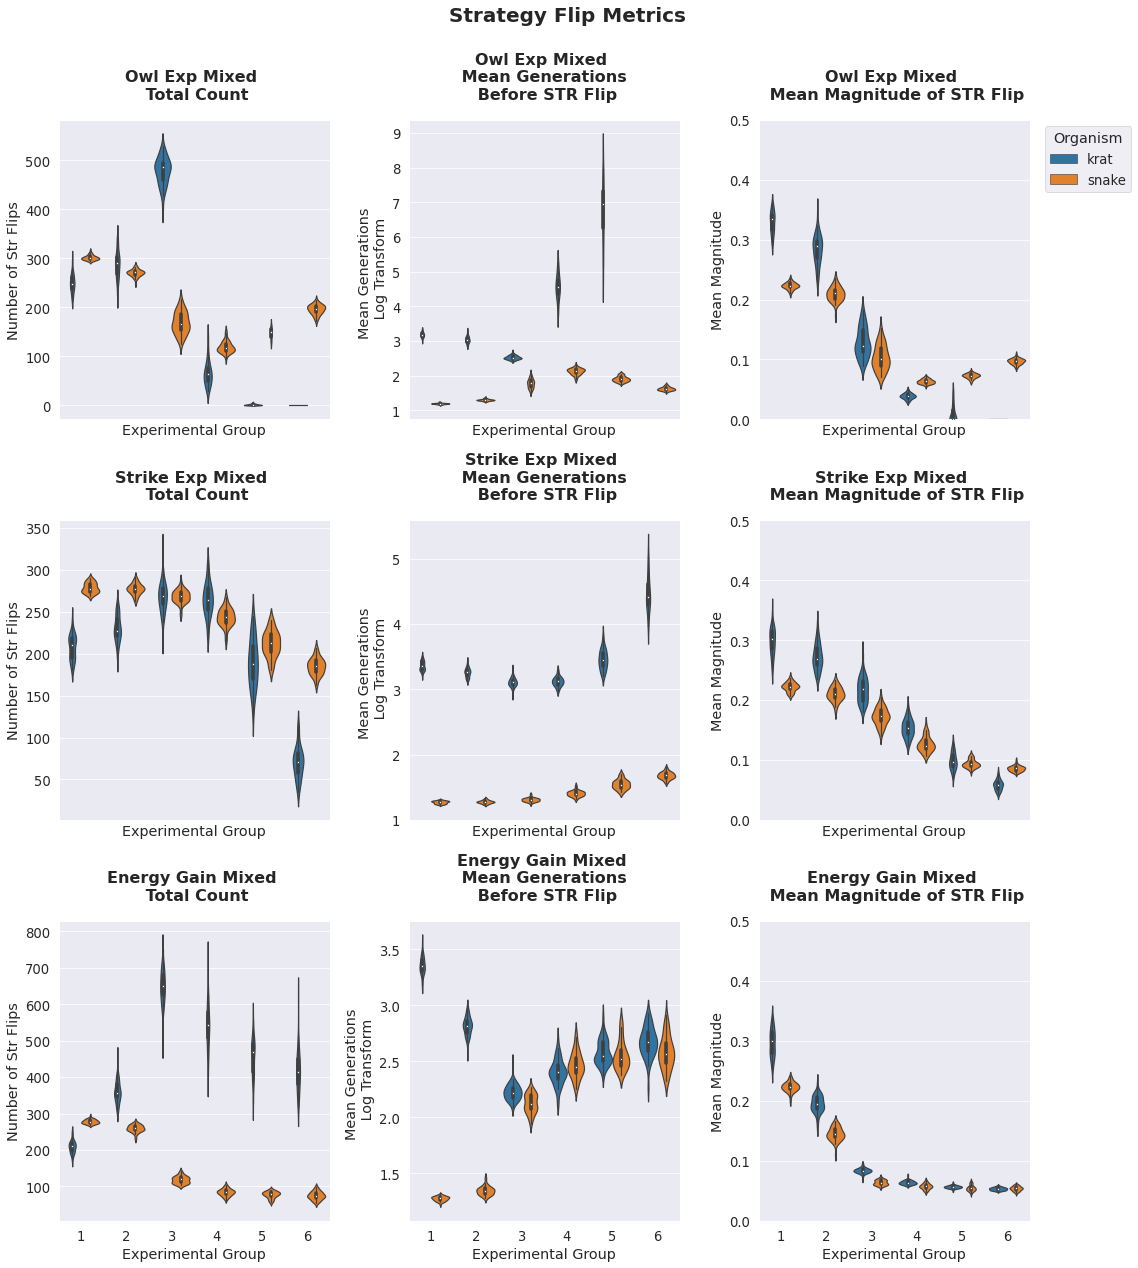

In [31]:
#######################
##### Official Chart ##
#######################
pure_exps = ['owl_exp_mixed','strike_exp_mixed','energy_gain_mixed']

fig, axes = plt.subplots(len(pure_exps), len(pure_exps), sharex=True,sharey=False, figsize=(16,18))

#sns.set(style="ticks")
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=1.5)

for i, title in enumerate(pure_exps):
    temp = temp_data(df=result,filter_val=title)
    g0 = sns.violinplot(ax=axes[i,0],
                        x="figure_label", y="count_str_flip",
                        hue="org", data=temp).set(
                                                  xlabel = "Experimental Group",
                                                  ylabel = "Number of Str Flips")
    axes[i,0].set_title('{} \n Total Count'.format(format_title(title)),fontdict= { 'fontsize': 16, 'fontweight':'bold'}, y =1.05)
    axes[i,0].legend_.remove()
    g1 = sns.violinplot(ax=axes[i,1],
                        x="figure_label", y='log_mgsf',
                        hue="org", data=temp).set(
                                                  xlabel = "Experimental Group",
                                                  ylabel = "Mean Generations \n Log Transform")
    axes[i,1].set_title('{} \n Mean Generations \n Before STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 16, 'fontweight':'bold'}, y =1.05)
    axes[i,1].legend_.remove()
    g2 = sns.violinplot(ax=axes[i,2],
                        x="figure_label", y="mean_magnitude_of_strategy_flip",
                        hue="org", data=temp, legend = False).set(
                                                  xlabel = "Experimental Group",
                                                  ylabel = "Mean Magnitude",
                                                  ylim=(0, 0.5))
    axes[i,2].set_title('{} \n Mean Magnitude of STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 16, 'fontweight':'bold'}, y =1.05)
    if i==0:
        axes[i,2].legend(bbox_to_anchor=(1.4, 1),loc='upper right', title='Organism')
    else:
        axes[i,2].legend_.remove()
    
    
    #height = .01
    #fig.figimage(eg_legend, 0, fig.bbox.ymax - height)


 

# A JointGrid


#gs.update(top=0.7)
fig.suptitle('Strategy Flip Metrics\n', fontweight='bold', size=20)
fig.tight_layout()

plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/mixed_str_flip_0411.png')
plt.show()

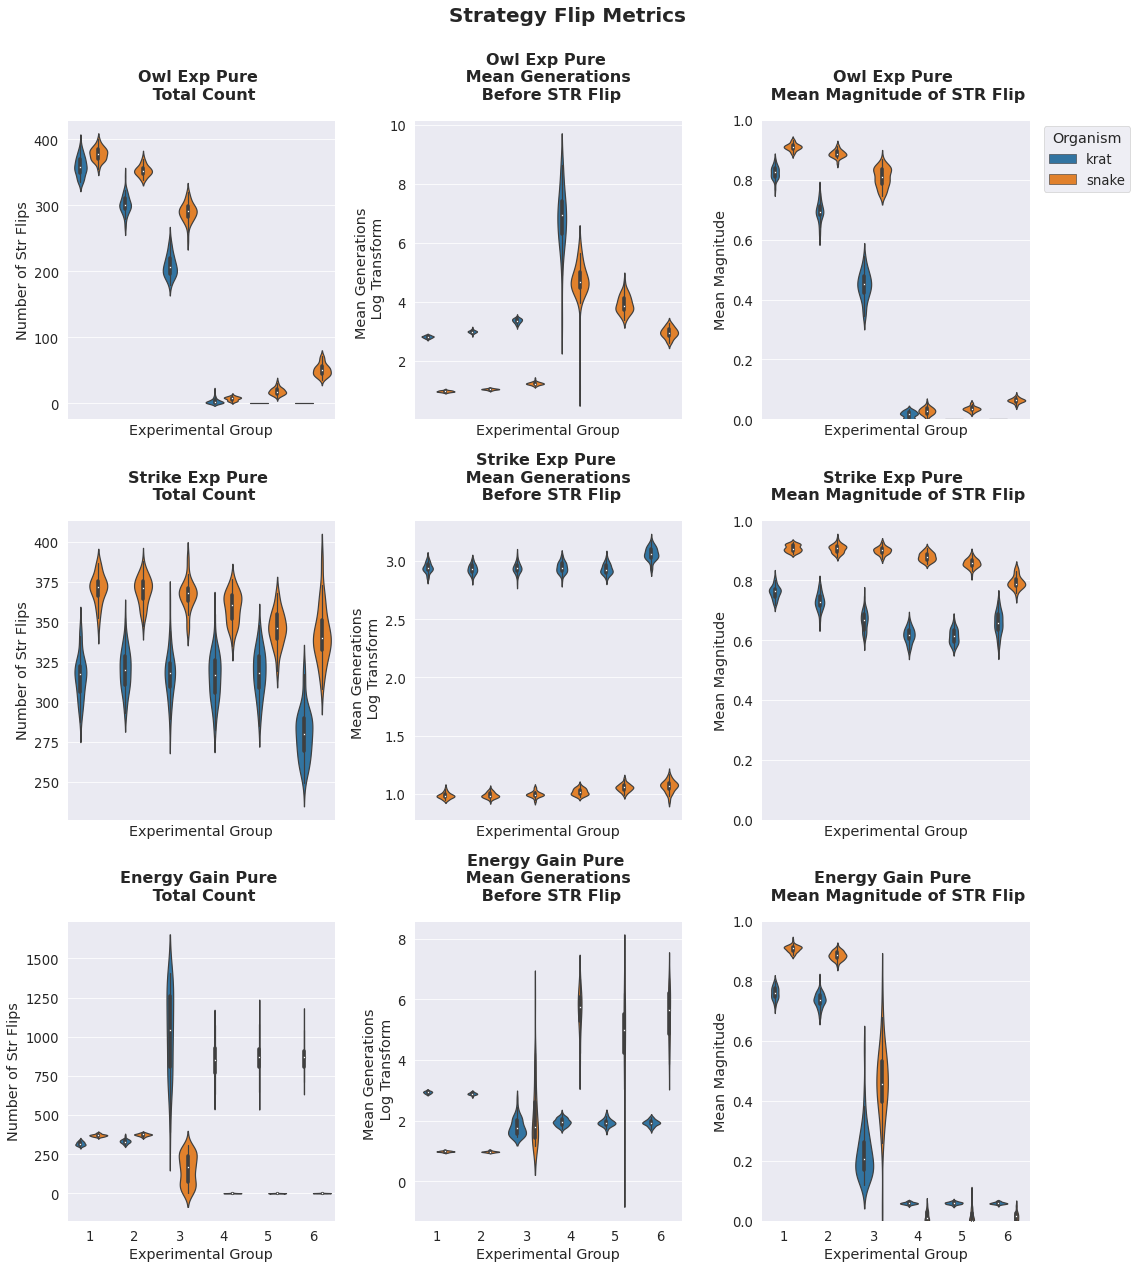

In [30]:
#######################
##### Official Chart ##
#######################
pure_exps = ['owl_exp_pure','strike_exp_pure','energy_gain_pure']

fig, axes = plt.subplots(len(pure_exps), len(pure_exps), sharex=True,sharey=False, figsize=(16,18))

#sns.set(style="ticks")
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=1.5)

for i, title in enumerate(pure_exps):
    temp = temp_data(df=result,filter_val=title)
    g0 = sns.violinplot(ax=axes[i,0],
                        x="figure_label", y="count_str_flip",
                        hue="org", data=temp).set(
                                                  xlabel = "Experimental Group",
                                                  ylabel = "Number of Str Flips")
    axes[i,0].set_title('{} \n Total Count'.format(format_title(title)),fontdict= { 'fontsize': 16, 'fontweight':'bold'}, y =1.05)
    axes[i,0].legend_.remove()
    g1 = sns.violinplot(ax=axes[i,1],
                        x="figure_label", y='log_mgsf',
                        hue="org", data=temp).set(
                                                  xlabel = "Experimental Group",
                                                  ylabel = "Mean Generations \n Log Transform")
    axes[i,1].set_title('{} \n Mean Generations \n Before STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 16, 'fontweight':'bold'}, y =1.05)
    axes[i,1].legend_.remove()
    g2 = sns.violinplot(ax=axes[i,2],
                        x="figure_label", y="mean_magnitude_of_strategy_flip",
                        hue="org", data=temp, legend = False).set(
                                                  xlabel = "Experimental Group",
                                                  ylabel = "Mean Magnitude",
                                                  ylim=(0, 1))
    axes[i,2].set_title('{} \n Mean Magnitude of STR Flip'.format(format_title(title)),fontdict= { 'fontsize': 16, 'fontweight':'bold'}, y =1.05)
    if i==0:
        axes[i,2].legend(bbox_to_anchor=(1.4, 1),loc='upper right', title='Organism')
    else:
        axes[i,2].legend_.remove()
    
    
    #height = .01
    #fig.figimage(eg_legend, 0, fig.bbox.ymax - height)


 

# A JointGrid


#gs.update(top=0.7)
fig.suptitle('Strategy Flip Metrics\n', fontweight='bold', size=20)
fig.tight_layout()

plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/pure_str_flip_0411.png')
plt.show()

<IPython.core.display.Javascript object>


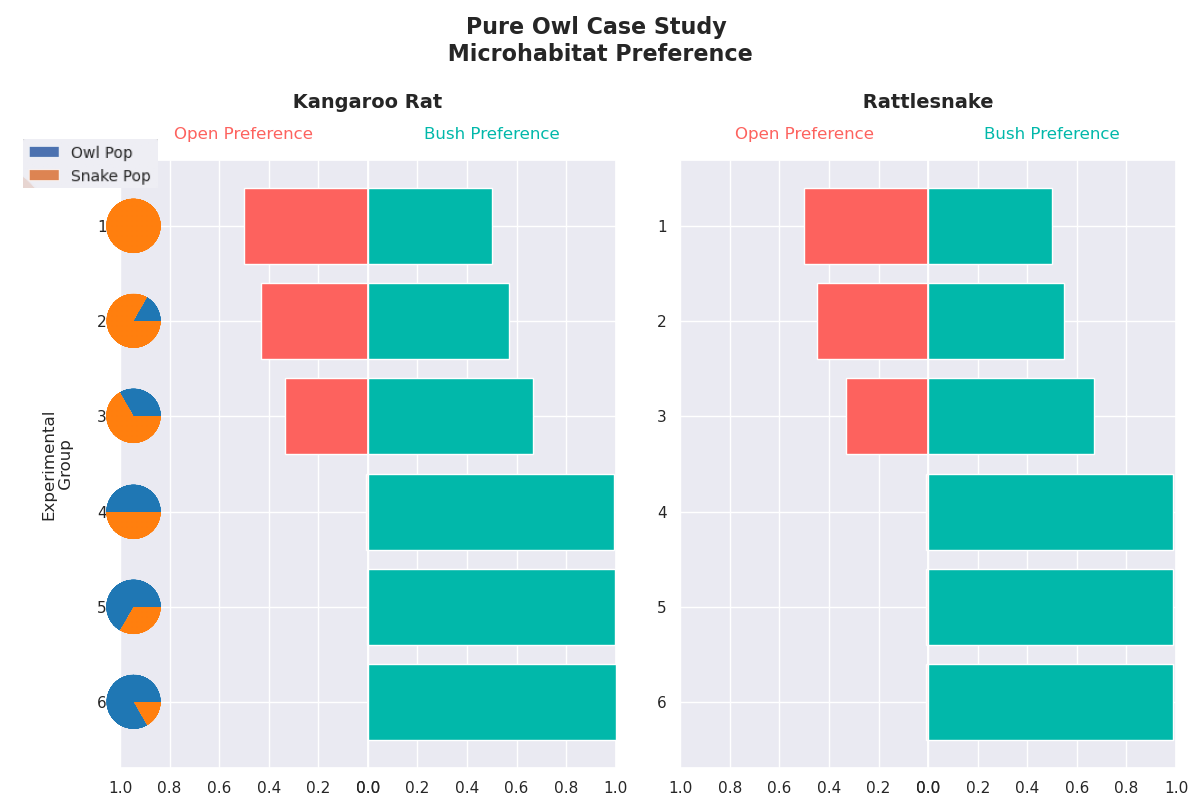

In [44]:
## working fig###
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import SubplotSpec
sns.set()
exps=['owl_exp_pure','owl_exp_pure']


font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'

title0 = 'Open Preference'
title1 = 'Bush Preference'

rows = 1
cols = 2

fig = plt.figure(figsize=(12, 8))
# grid for pairs of subplots
grid = plt.GridSpec(rows, cols)
grid.update(left=0.1, top=0.8,bottom=0.04,right=0.98,wspace=.13,hspace=.87)


for i,exp in enumerate(exps):
    # create fake subplot just to title pair of subplots
    fake = fig.add_subplot(grid[i])
    data=get_data(exp)
    index = data.index
    column0 = data['krat_open']
    column1 = data['krat_bush']
    #  '\n' is important
    if (i % 2)==0:
        fake.set_title('\n Kangaroo Rat \n\n', fontweight='semibold', size=14)
        column0 = data['krat_open']
        column1 = data['krat_bush']
    else:
        fake.set_title('\n Rattlesnake \n\n', fontweight='semibold', size=14)
        column0 = data['snake_open']
        column1 = data['snake_bush']
    fake.set_axis_off()

    # create subgrid for two subplots without space between them
    # <https://matplotlib.org/2.0.2/users/gridspec.html>
    gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[i], wspace=0)

    # real subplot #1
    ax = fig.add_subplot(gs[0])
    ax.set_title(title0, fontsize=12, pad=15, color=color_red, **hfont)
    ax.barh(index, column0, align='center', color=color_red, zorder=10)
    ax.set(xlim=(0,1))
    ax.invert_xaxis()
    # hide ticks and labels
    #ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

    # real subplot #2
    ax2 = fig.add_subplot(gs[1], sharey=ax)
    ax2.barh(index, column1, align='center', color=color_blue, zorder=10)
    ax2.set_title(title1, fontsize=12, pad=15, color=color_blue, **hfont)
    ax2.invert_yaxis()
    # hide ticks and labels
    ax2.tick_params(left=False, labelleft=False)
    ax2.set(xlim=(0,1))
    if exp in ['owl_exp_pure','owl_exp_mixed'] and (i % 2)==0:
        for j in range(1,7):
            ax.set(ylabel = "Experimental\n Group \n")
            name = 'owl_figure_label_{}'.format(j)
            offset_image(j, name, ax2,zoom=0.2,xval=-170)
            get_legend(abrev_name='owl',coord=0,ax=ax2,zoom=0.8,x=-200,y=45)
    elif exp in ['strike_exp_pure','strike_exp_mixed'] and (i % 2)==0:
        for j in range(1,7):
            ax.set(ylabel = "Experimental\n Group \n")
            name = 'strike_success_figure_label_{}'.format(j)
            offset_image(j, name, ax2,zoom=0.08,xval=-170)
            get_legend(abrev_name='ss',coord=0,ax=ax2,zoom=0.5,x=-170,y=20)
    elif exp in ['energy_gain_pure','energy_gain_mixed'] and (i % 2)==0:
        for j in range(1,7):
            ax.set(ylabel = "Experimental\n Group \n")
            name = 'energy_gain_figure_label_{}'.format(j)
            offset_image(j, name, ax2,zoom=0.08,xval=-170)
            get_legend(abrev_name='energy_gain',coord=0,ax=ax2,zoom=0.5,x=-170,y=20)
    

fig.patch.set_facecolor('white')
fig.suptitle('Pure Owl Case Study \n Microhabitat Preference \n', fontweight='bold', size=16)
plt.savefig('/home/mremington/Documents/uumarrty_post_sim/uumarrty_post_sim_analysis/images/figs/pure_owl_exp_mh_0414.png')
#fig.tight_layout()